In [1]:
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import gridspec, cm
FONT_SIZE = 17

from random import shuffle, seed
SEED_NUMBER=42

from pathlib import Path

In [2]:
proj_path = Path().resolve().parent
print(proj_path)

/home/clem/Documents/Vectorpack/experiments_vector_paper/results_data


In [3]:
file_P = proj_path / "Panigrahy_multidim_OPT.csv"
file_I = proj_path / "Irregular_multidim_OPT.csv"
file_T = proj_path / "Triplet_multidim.csv"

In [4]:
family_list = ['FF',
               'FFD', 'FFD-Dyn',
               'BFD-T1', 'BFD-T1-Dyn',
               'BFD-T2', 'BFD-T2-Dyn',
               'BFD-T3', 'BFD-T3-Dyn',
               'BF', 'BF-Dyn',
               'WFD-T1', 'WFD-T1-Dyn',
               'WFD-T2', 'WFD-T2-Dyn',
               'WFD-T3', 'WFD-T3-Dyn',
               'WF', 'WF-Dyn',
               'BCS-DP1', 'BCS-DP1-Dyn', 'BCS-DP1-Bin', 
               'BCS-DP2', 'BCS-DP2-Dyn', 'BCS-DP2-Bin', 
               'BCS-DP3', 'BCS-DP3-Dyn', 'BCS-DP3-Bin', 
               'BCS-NormDP', 'BCS-NormDP-Dyn', 'BCS-NormDP-Bin',
               'BCS-L2Norm', 'BCS-L2Norm-Dyn', 'BCS-L2Norm-Bin',
               'BCS-TFSum', 'BCS-TFSum-Dyn', 'BCS-TFSum-Bin',
               'BCS-TFMin', 'BCS-TFMin-Dyn', 'BCS-TFMin-Bin',
               
               'BCS', 'BCS-Dyn', 'BCS-Bin',
               #'Pairing-BS', 'Pairing-BS-Dyn', 'Pairing-BS-Bin',
               #'WFDm-BS', 'WFDm-BS-Dyn',
               'MB-Pairing', 'MB-Pairing-Dyn', 'MB-Pairing-Bin',
               'MB-WFD', 'MB-WFD-Dyn',
               
               'meta'
              ]

def get_family(alg_name):
    ssplit = alg_name.split('-')
    s = ssplit[0]
    if s == 'MB':
        if (ssplit[1] == "BFD") or (ssplit[1] == "WFD"):
            s+= "-WFD"
        elif ssplit[1] == "Pairing":
            s+= "-" + ssplit[1]
        
        if ("Dyn" in alg_name) or ("Ratio" in alg_name):
            s+="-Dyn"
        elif ("Bin" in alg_name):
            s+="-Bin"
        
    elif s == 'BCS':
        #s+= "-" + ssplit[1]
        if ("Dyn" in alg_name) or ("Ratio" in alg_name):
            s+="-Dyn"
        elif ("Bin" in alg_name):
            s+="-Bin"

    else:
        if "T1" in alg_name:
            s+= "-T1"
        elif "T2" in alg_name:
            s+= "-T2"
        elif "T3" in alg_name:
            s+= "-T3"
            
        if "Rank" in alg_name:
            s = "Fit-Rank"
        
        if ("Dyn" in alg_name) or ("Ratio" in alg_name):
            s+="-Dyn"
    
    if s in family_list:
        return s
    else:
        print("Unknown algo name", alg_name, s)
        return -1
    
def is_family(alg_name, family_name):
    fam = get_family(alg_name)
    return fam == family_name

def create_family_dict(alg_list):
    d = defaultdict(list)
    
    for alg_name in alg_list:
        fam = get_family(alg_name)
        if fam != -1:
            d[fam].append(alg_name)
        
    return d

def get_simple_family(alg_name):
    ssplit = alg_name.split('-')
    s = ssplit[0]
    
    if s == 'MB':
        if ssplit[1] == "Pairing":
            return s+"-Pairing"
        else:
            return s+"-WFD"
    else:
        return s
    
def create_simple_family_dict(alg_list):
    d = defaultdict(list)
    
    for alg_name in alg_list:
        fam = get_simple_family(alg_name)
        if fam != -1:
            d[fam].append(alg_name)
    return d

In [5]:
def get_score(s):
    score = 0
    if "T1" in s:
        score+= 0.1
    elif "T2" in s:
        score+= 0.2
    elif "T3" in s:
        score+= 0.3

    if s == "FF":
        score = 0
    elif s.startswith('FF'):
        score+= 1
    elif s.startswith('BF'):
        score+= 2
    elif s.startswith('WF'):
        score+= 3
    elif s.startswith('BCS'):
        score+= 4
    elif s.startswith('MB-WFD') or s.startswith('MB-BFD'):
        score+= 5
    elif s.startswith('MB-Pairing'):
        score+= 6
    elif s.startswith('meta-'):
        score+=99
    return score

In [6]:
def rename_algos(algo_list):
    return [x.replace("WFDm-BS", "MB-WFD").replace("BFDm-BS", "MB-BFD").replace("Pairing-BS", "MB-Pairing").replace("ReciprocAvg", "RecipAvg") for x in algo_list]

## Get results

In [7]:
def load_df(filename, with_classes=True, **kwargs):
    df = pd.read_csv(filename, sep='\t')
    #if with_OPT:
    if "OPT" in df.columns:
        # First 3 columns are ['instance_name', 'LB', 'OPT']
        start_cols = 3
    else:
        start_cols = 2
        # First 2 columns are ['instance_name', 'LB']
    
    # Rename some algorithms
    df.columns = rename_algos(df.columns)
      
    all_column_names = df.columns[start_cols:]
    
    if (len(all_column_names) % 2) != 0:
        print(f"ERROR: {len(all_column_names)} {len(df.columns)}")

    alg_names = [x for x in all_column_names if not "_time" in x]
    nb_algos = len(alg_names)
    
    alg_names_multi = [x for x in alg_names if x.startswith("MB-")]
    
    # Complement MB results with the solutions of FF
    for alg in alg_names_multi:
        df.loc[df[alg] == -1, alg] = df['FF']
    
    for x in alg_names:
        if '.' in x:
            print("Error ALGO NAME:", x)
    
    best_LB_OPT = df["LB"].copy()
    if "OPT" in df.columns:
        # complement with optimal values
        idx = df[df["OPT"] != -1].index
        best_LB_OPT.loc[idx] = df.loc[idx]["OPT"]
        df.drop(['OPT'], axis=1, inplace=True)
    df.insert(2, 'LB_or_OPT', best_LB_OPT)
    
    df.insert(1, 'n', df['instance_name'].apply(lambda x: int(x.split('_')[1])))
    df.insert(2, 'd', df['instance_name'].apply(lambda x: int(x.split('_')[2])))
    if with_classes:
        df.insert(1, 'class', df['instance_name'].apply(lambda x: x.split('_')[0][5:]))
        
    df.drop(['instance_name'], axis=1, inplace=True)
    
    return df, alg_names, alg_names_multi

In [8]:
def get_results(df, alg_names, by_list, group_as_index=False):
    sub_df = df[by_list].copy()
    
    df["best_sol"] = df[alg_names].min(axis=1)

    time_cols = [i+'_timems' for i in alg_names]
    
    eps = df[alg_names].apply(lambda x: (round(x / df["LB_or_OPT"] - 1, 3))*100) # *100 to get a percentage value
    time = df[time_cols].apply(lambda x: round(x, 4))
    time.columns = alg_names
    diff = df[alg_names].apply(lambda x: x - df["LB_or_OPT"])
    diff_best = df[alg_names].apply(lambda x: x - df["best_sol"])
    match_LB = df[alg_names].apply(lambda x: x == df["LB"])
    
    best = df[alg_names].apply(lambda x: x == df["best_sol"])
    
    eps = pd.concat([sub_df, eps], axis=1).groupby(by=by_list, as_index=group_as_index).mean()
    time = pd.concat([sub_df, time], axis=1).groupby(by=by_list, as_index=group_as_index).mean()
    diff = pd.concat([sub_df, diff], axis=1).groupby(by=by_list, as_index=group_as_index).mean()
    diff_best = pd.concat([sub_df, diff_best], axis=1).groupby(by=by_list, as_index=group_as_index).mean()
    
    best = pd.concat([sub_df, best], axis=1).groupby(by=by_list, as_index=group_as_index).sum()
    match_LB = pd.concat([sub_df, match_LB], axis=1).groupby(by=by_list, as_index=group_as_index).sum()
    
    return eps, time, diff, diff_best, best, match_LB

In [9]:
def filter_algo_list(algo_list, remove_prefix):
    def predicate(alg, remove_prefix):
        for s in remove_prefix:
            if alg.startswith(s):
                #print("removing", alg)
                return True
        return False
    
    l = [alg for alg in algo_list if not predicate(alg, remove_prefix)]
    return l

# Load dataframes

In [10]:
df_P, all_algos, multi_algos = load_df(file_P, with_classes=True)
df_I, _, _ = load_df(file_I, with_classes=True)
df_T, _, _ = load_df(file_T, with_classes=True)

print(f"Loaded {len(all_algos)} algos including {len(multi_algos)} MB algos!")

Loaded 351 algos including 76 MB algos!


# Compare algos with Unit weights only

In [11]:
alg_names_unit = [x for x in all_algos if "-Unit" in x and not "T3" in x]
alg_names_unit.insert(0, 'FF')
print(f"There are {len(alg_names_unit)} Unit algos")

There are 34 Unit algos


In [12]:
# Filter out BF and WF algos
alg_names_unit = [x for x in alg_names_unit if not "BF-" in x and not "WF-" in x]

In [13]:
# For all Centric + Multibin algos
unit_results_P = get_results(df_P, alg_names_unit, ['class', 'n', 'd'], group_as_index=True)
unit_results_I = get_results(df_I, alg_names_unit, ['class', 'n', 'd'], group_as_index=True)
unit_results_T = get_results(df_T, alg_names_unit, ['class', 'n', 'd'], group_as_index=True)

# results contains: eps, time, diff, diff_best, best, match_LB

## Find algos consistently outperformed by others
There are none for Centric. Even BF and WF are better than DotProduct1 for some instances.

In [ ]:
df = df_T
algs = alg_names_unit

nb_instances = df.shape[0]
for algo_test in algs:
    counts = df[algs].apply(lambda x: x <= df[algo_test]).sum()
    l = list(counts[counts == nb_instances].index)
    l.remove(algo_test)
    if (len(l) > 0):
        #to_remove = to_remove.union(l)
        print(f"{algo_test}: {len(l)} are better than me")
        if (len(l) < 10):
            print('\t', l)

## Find algorithms performing equally

In [ ]:
df = df_P
algs = alg_names_unit

nb_instances = df.shape[0]
sub_list = algs.copy()
new_list = []
for i in range(len(algs)):
    algo_test = sub_list.pop(0)
    new_list.append(algo_test)
    # Find algos performing equally to algo_test
    counts = df[sub_list].apply(lambda x: x == df[algo_test]).sum()
    l = list(counts[counts == nb_instances].index)
    if (len(l) != 0):
        # If some are found, remove them from the sub_list
        print(f"{algo_test} identical to: {l}")
        sub_list = [x for x in sub_list if not x in l]
    if (len(sub_list) == 0):
        break
# Sub_list contains 'unique' algos
print(f"There are {len(new_list)} 'unique' algos")

## Find best algos for each class and parameters

In [ ]:
algs = alg_names_unit

eps = unit_results_P[0]
for c in range(1,10): # For Panigrahy dataframe
    print("\tClass", c)
    
    print("\t\tPercentage err to LB")
    eps_avg = eps.loc[str(c)][algs].mean()
    eps_avg.sort_values(ascending=True, inplace=True)
    print(eps_avg.head(10))
    
    #print("\t\tAvg. diff to best")
    #diff_best_avg = diff_best.loc[str(c)][algs].mean()
    #diff_best_avg.sort_values(ascending=True, inplace=True)
    #print(diff_best_avg.head(10))

In [ ]:
algs = alg_names_unit

eps = unit_results_I[0]
for c in range(1,7): # For Irregular dataframe
    print("\tClass", c)
    
    print("\t\tPercentage err to LB")
    eps_avg = eps.loc[str(c)][algs].mean()
    eps_avg.sort_values(ascending=True, inplace=True)
    print(eps_avg.head(10))
    
    #print("\t\tAvg. diff to best")
    #diff_best_avg = diff_best.loc[str(c)][algs].mean()
    #diff_best_avg.sort_values(ascending=True, inplace=True)
    #print(diff_best_avg.head(10))

In [ ]:
algs = alg_names_unit

eps = unit_results_T[0]
for c in ['C', 'F']: # For Triplet dataframe
    print("\tClass", c)
    
    print("\t\tPercentage err to LB")
    eps_avg = eps.loc[str(c)][algs].mean()
    eps_avg.sort_values(ascending=True, inplace=True)
    print(eps_avg.head(10))
    
    #print("\t\tAvg. diff to best")
    #diff_best_avg = diff_best.loc[str(c)][algs].mean()
    #diff_best_avg.sort_values(ascending=True, inplace=True)
    #print(diff_best_avg.head(10))

## Plots

In [22]:
def create_small_colors(n):
    cmap = cm.get_cmap('nipy_spectral')
    #cmap = cm.get_cmap('turbo')
    if n > 1:
        c = []
        for i in range(n):
            c.append(cmap(float(i/(n-1))))
        #shuffle(c)
    else:
        c = [cmap(0)]
    return c

In [23]:
MARKS = ['o', 'v', 'd', '*', '^', 'X']

def create_markers(n):
    m = len(MARKS)
    return [MARKS[i%m] for i in range(n)]

In [21]:
list_all_markers = {'.': 'point', ',': 'pixel', 'o': 'circle', 'v': 'triangle_down', '^': 'triangle_up', '<': 'triangle_left', '>': 'triangle_right', '1': 'tri_down', '2': 'tri_up', '3': 'tri_left', '4': 'tri_right', '8': 'octagon', 's': 'square', 'p': 'pentagon', '*': 'star', 'h': 'hexagon1', 'H': 'hexagon2', '+': 'plus', 'x': 'x', 'D': 'diamond', 'd': 'thin_diamond', '|': 'vline', '_': 'hline', 'P': 'plus_filled', 'X': 'x_filled', 0: 'tickleft', 1: 'tickright', 2: 'tickup', 3: 'tickdown', 4: 'caretleft', 5: 'caretright', 6: 'caretup', 7: 'caretdown', 8: 'caretleftbase', 9: 'caretrightbase', 10: 'caretupbase', 11: 'caretdownbase'}
BIG_MARKS = [k for k in list_all_markers.keys()]
print(len(BIG_MARKS))

37


In [24]:
def create_big_markers(n):
    m = len(BIG_MARKS)
    return [BIG_MARKS[i%m] for i in range(n)]

In [25]:
def simplify_family_dict(fam_dict):
    new_dict = defaultdict(list)
    
    for fam, fam_list in fam_dict.items():
        sp = fam.split("-")
        s = sp[0]
        if len(sp) > 1 and sp[1].startswith('T'):
            s+= "-" + sp[1]
        
        if len(sp) > 1 and sp[0] == "MB":
            s+= "-" + sp[1]
        
        new_dict[s].extend(fam_list)
        
    return new_dict

In [26]:
def plot_summary_family(x_data, y_data, alg_list,
                 stitle, xlabel, ylabel,
                 **kwargs):
    
    # kwargs parameters
    if "bbox_anchor" in kwargs:
        bbox_anchor = kwargs["bbox_anchor"]
    else:
        bbox_anchor = (kwargs.get("bbox_anchor_x", 0.5), kwargs.get("bbox_anchor_y", -0.1))
    
    ncols = kwargs.get("ncols", 5)

    x = x_data[alg_list].mean()
    y = y_data[alg_list].mean()
    
    fig = plt.figure(figsize=(15,10))
    
    # To sort the algos by FFD, BFD, WFD, BCS, MB order
    alg_list.sort(key=lambda x: get_score(x))
    
    fam_dict = create_family_dict(alg_list)
    if kwargs.get("simplify_dict", True):
        fam_dict = simplify_family_dict(fam_dict)
    
    marker_list = create_big_markers(len(alg_list))
    #marker_list = create_markers(len(alg_list))
    color_list = create_small_colors(len(fam_dict))
    seed(SEED_NUMBER)
    shuffle(color_list)
    
    i = 0
    j = 0
    legend_markers = []
    legend_names = []
    for fam, fam_list in fam_dict.items():
        n_algos = len(fam_list)
        
        for alg in fam_list:
            plt.scatter(x[alg], y[alg], color=color_list[i], marker=marker_list[j], s=100)
            legend_markers.append(plt.Line2D([0,0],[0,0],color=color_list[i], marker=marker_list[j], linestyle=''))
            legend_names.append(alg)
            j+=1
        i+=1
        
    plt.title(stitle, fontsize=FONT_SIZE+4)
    plt.xlabel(xlabel, fontsize=FONT_SIZE+4)
    plt.ylabel(ylabel, fontsize=FONT_SIZE+4)
    plt.xticks(fontsize=FONT_SIZE)
    plt.yticks(fontsize=FONT_SIZE)
    
    if kwargs.get("show_legend", True):
        legend_size = kwargs.get("legend_size", FONT_SIZE-5)
        fig.legend(legend_markers, legend_names, numpoints=1, loc='lower center',
                   fontsize=legend_size, ncol=ncols, bbox_to_anchor=bbox_anchor)
    
    if kwargs.get("log_scale", False):
        plt.xscale('log')
    plt.show()
    
    filename = kwargs.get("filename", None)
    if filename:
        fig.savefig(filename, bbox_inches='tight')
    #return plt


## Plot for each class

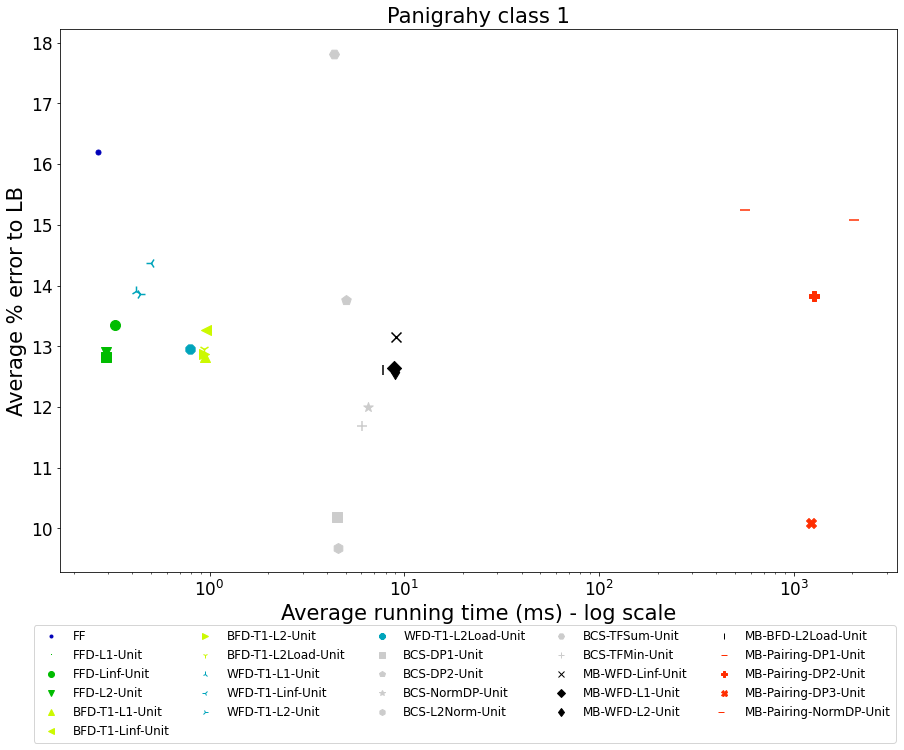

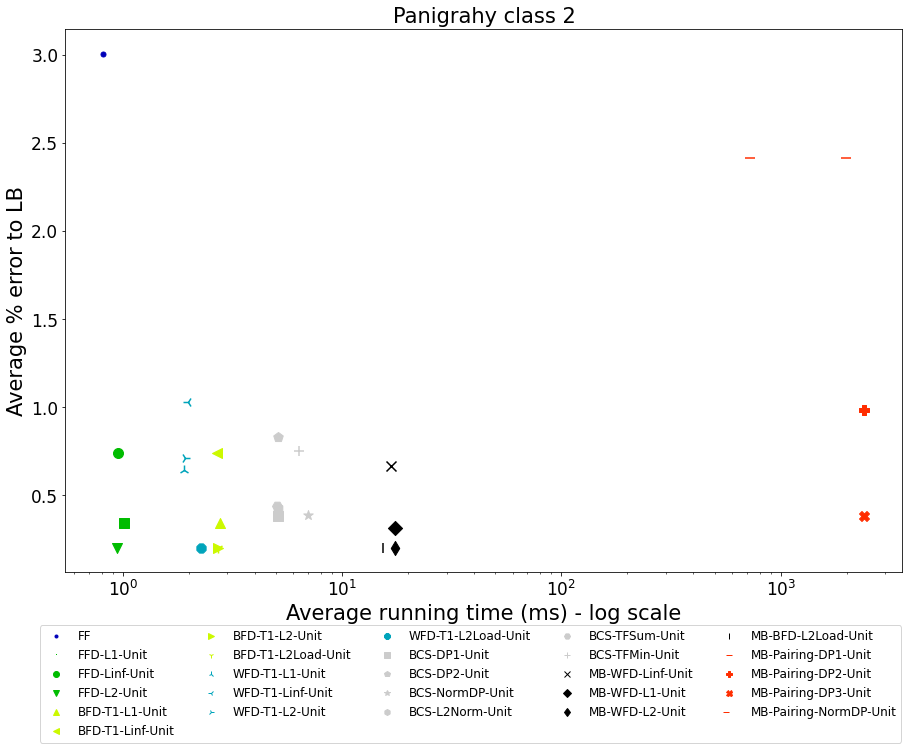

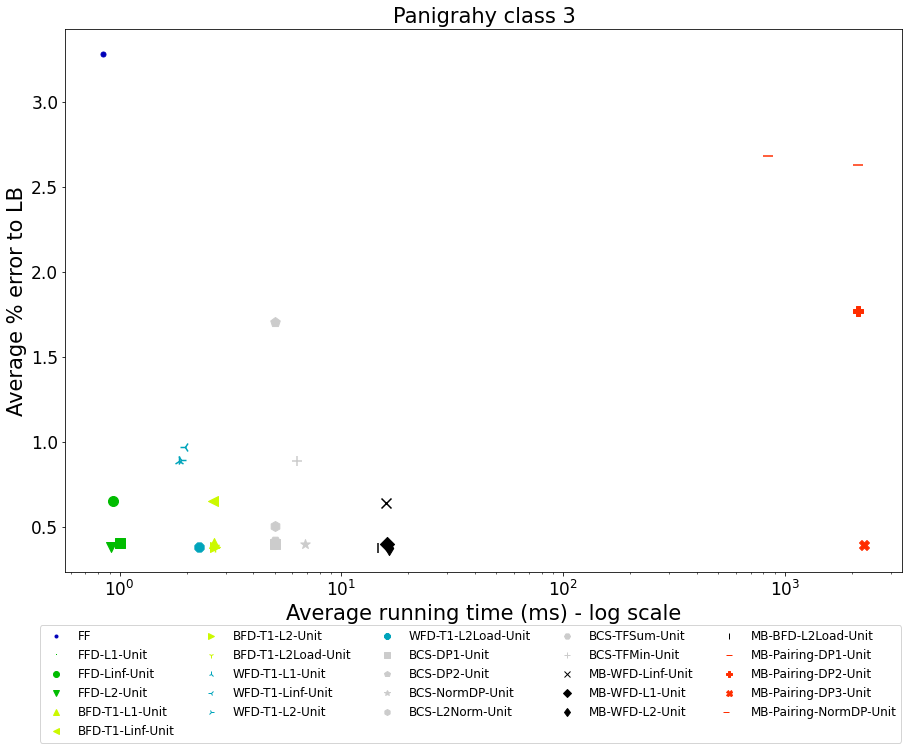

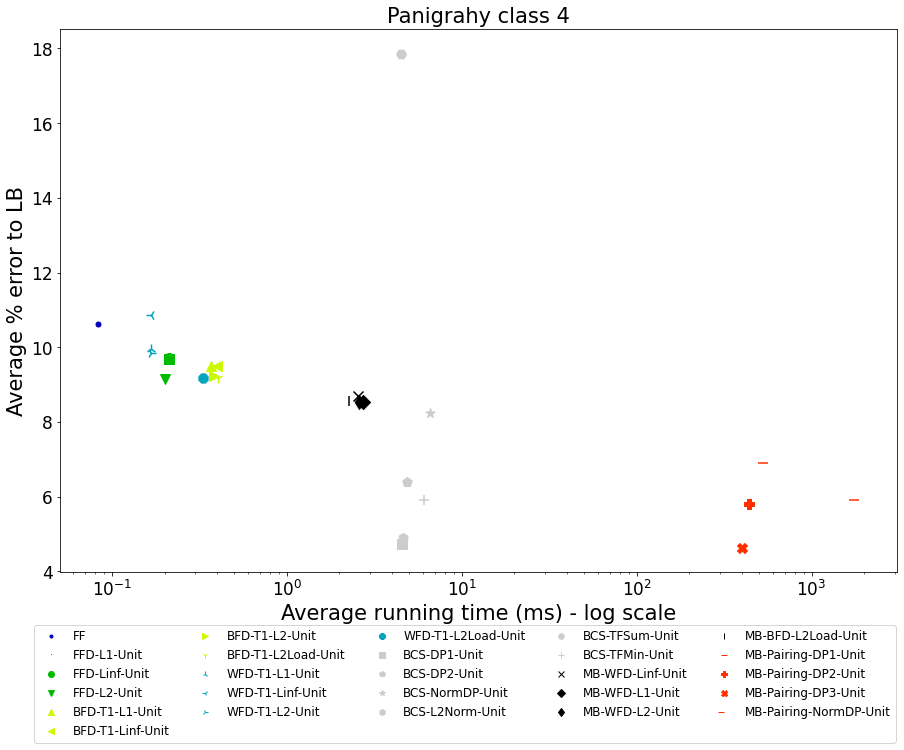

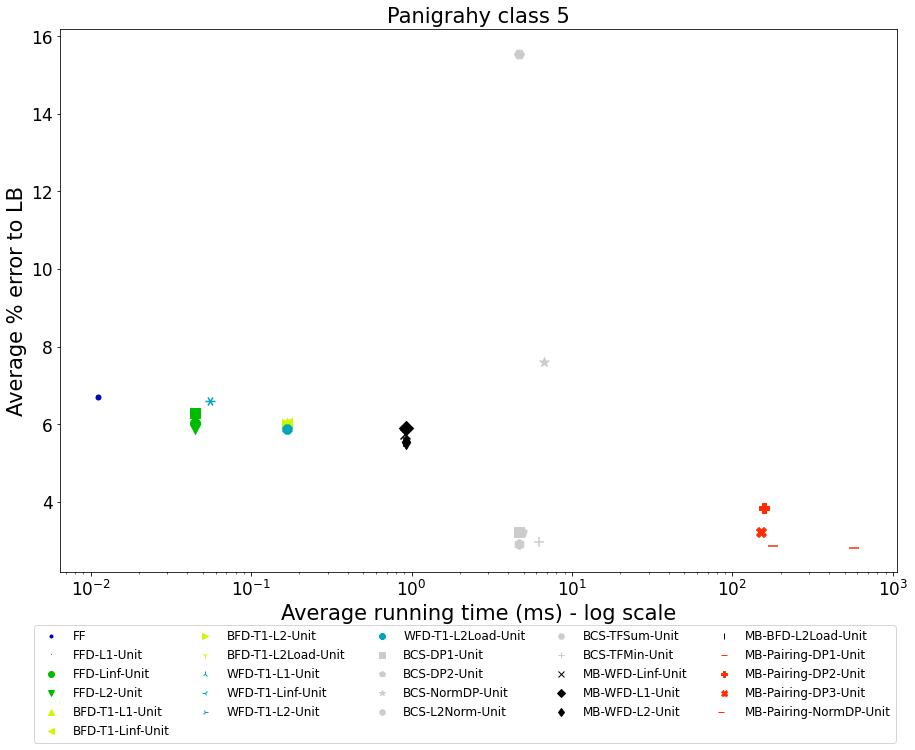

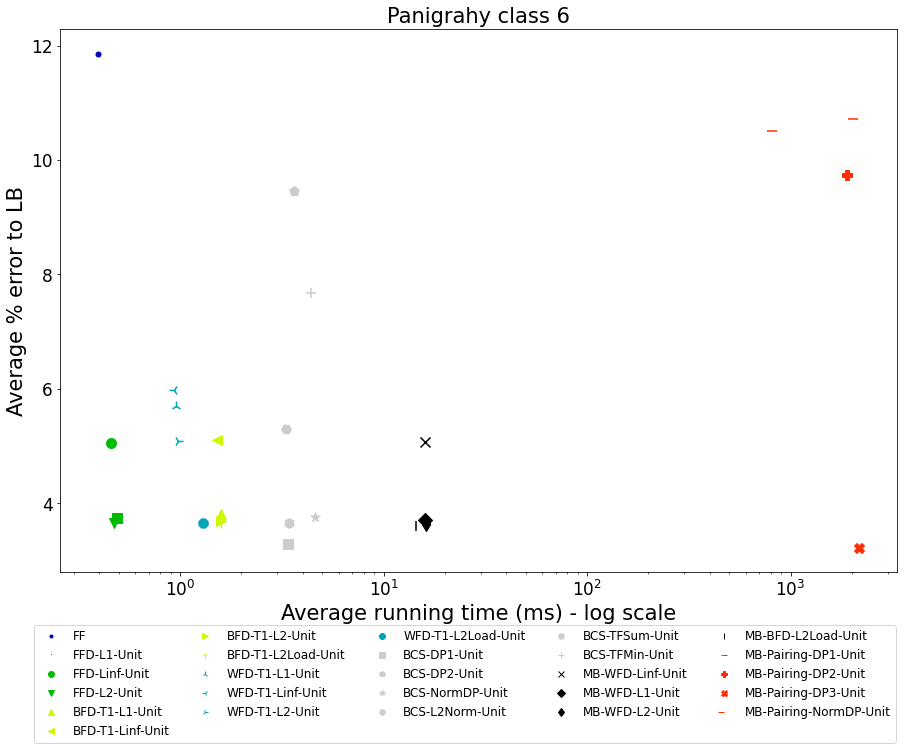

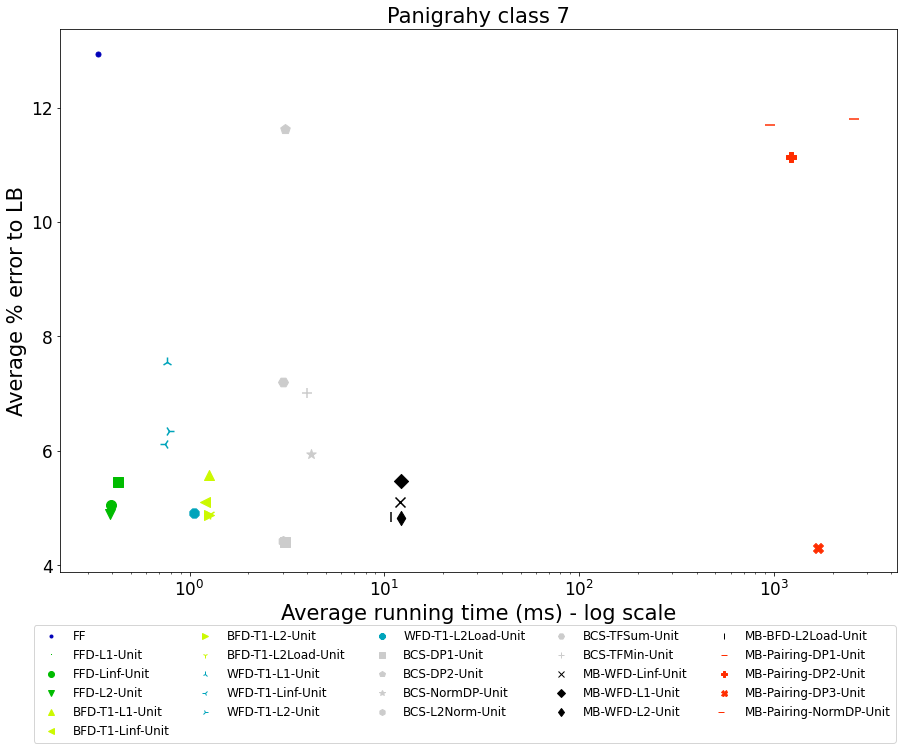

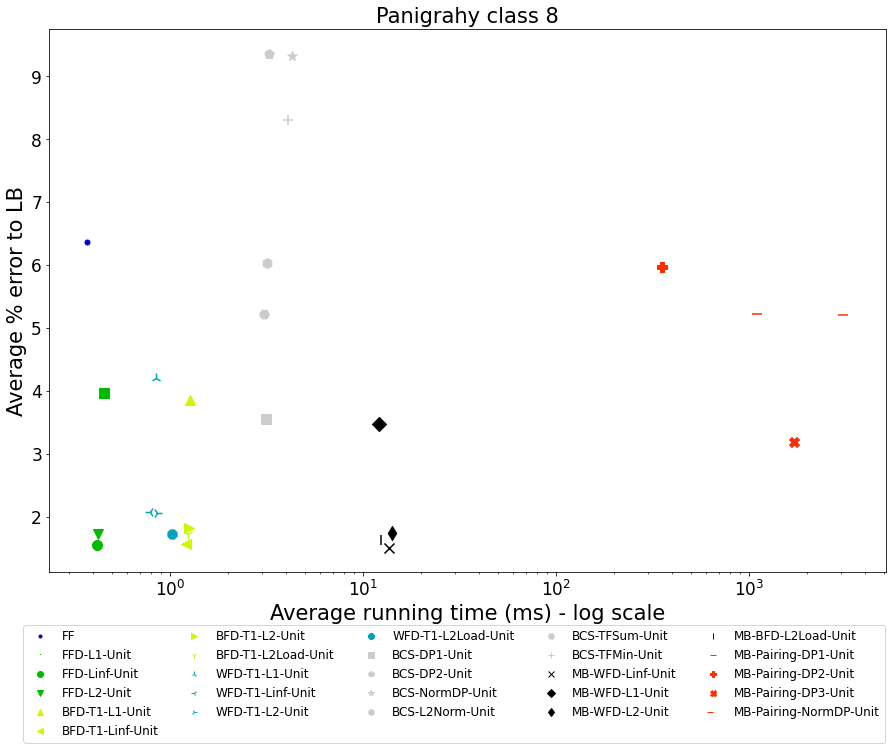

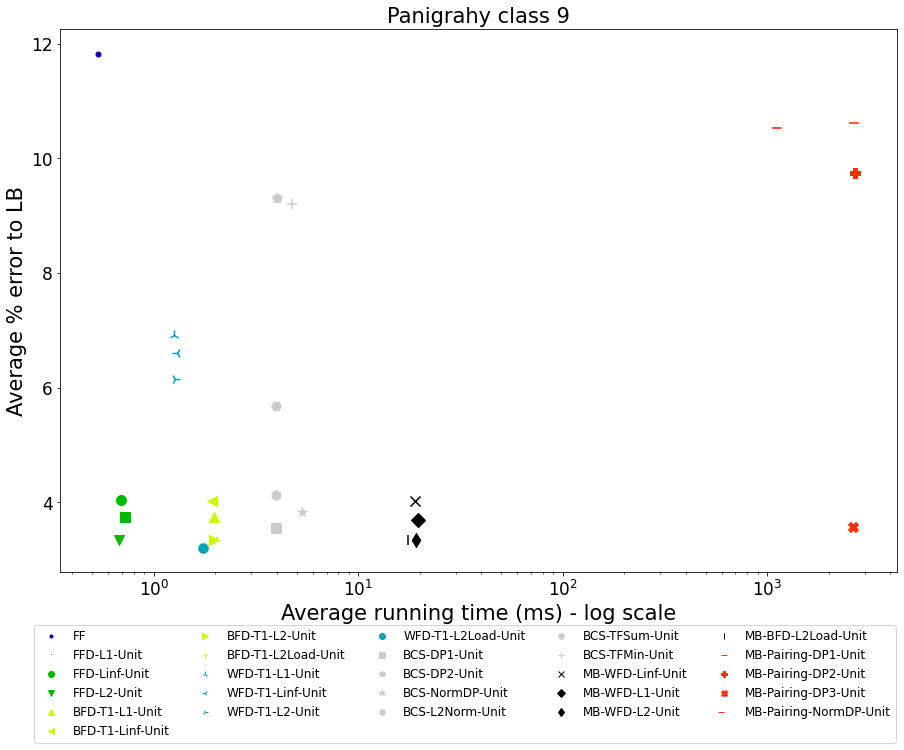

In [30]:
for c in range(1,10):
    fname = proj_path / f"plots/all_classes/unit_P{c}.pdf"
    plot_summary_family(unit_results_P[1].loc[str(c)], unit_results_P[0].loc[str(c)], alg_names_unit,
            f"Panigrahy class {c}", "Average running time (ms) - log scale", "Average % error to LB",
            log_scale=True, filename=fname,
            bbox_anchor_y=-0.12)

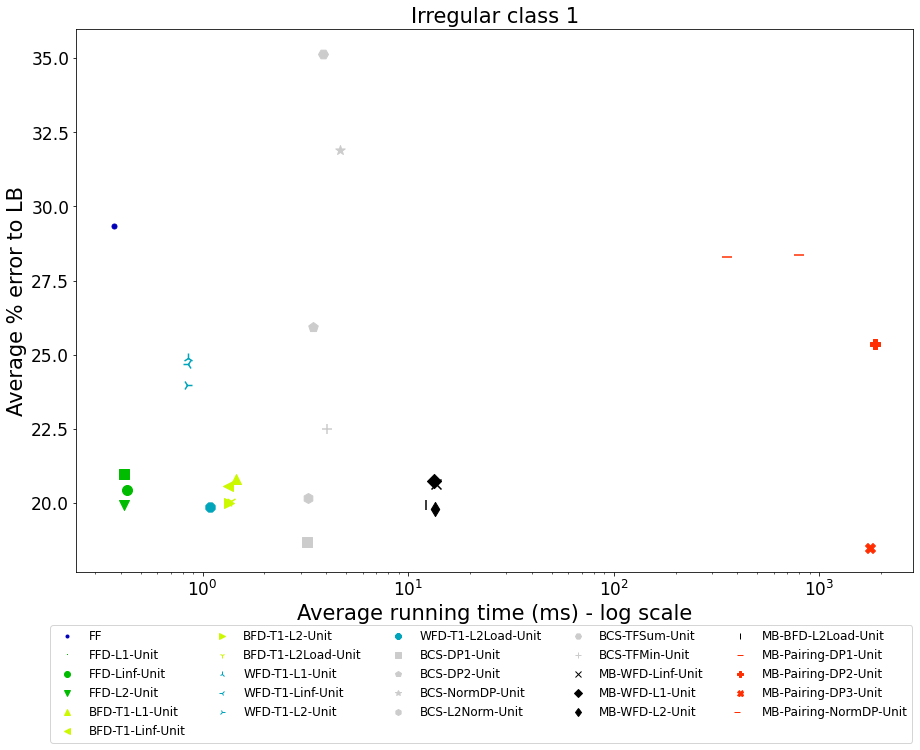

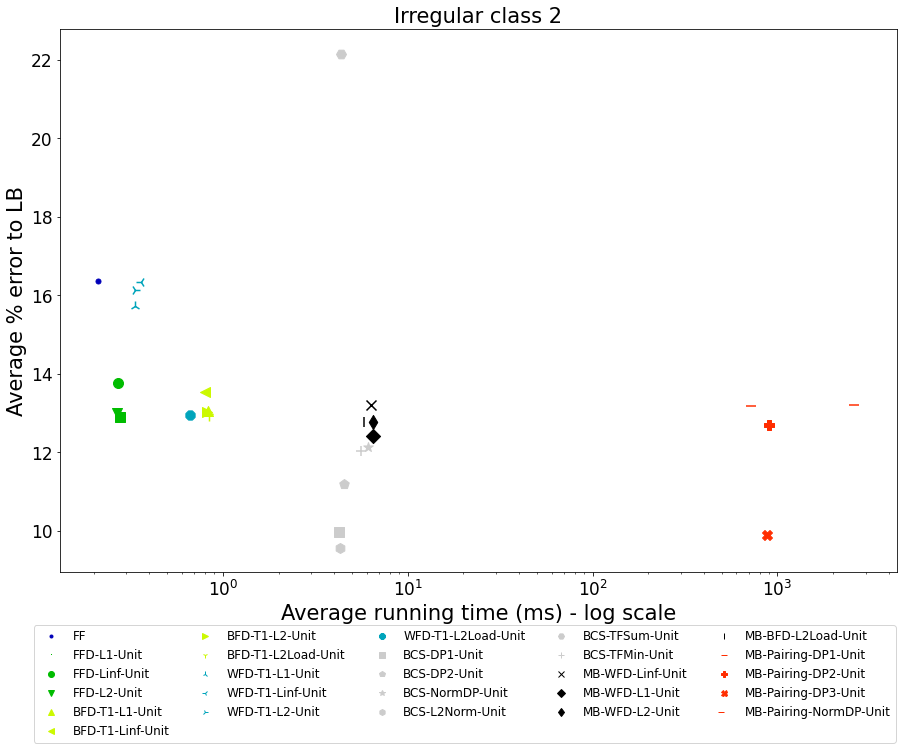

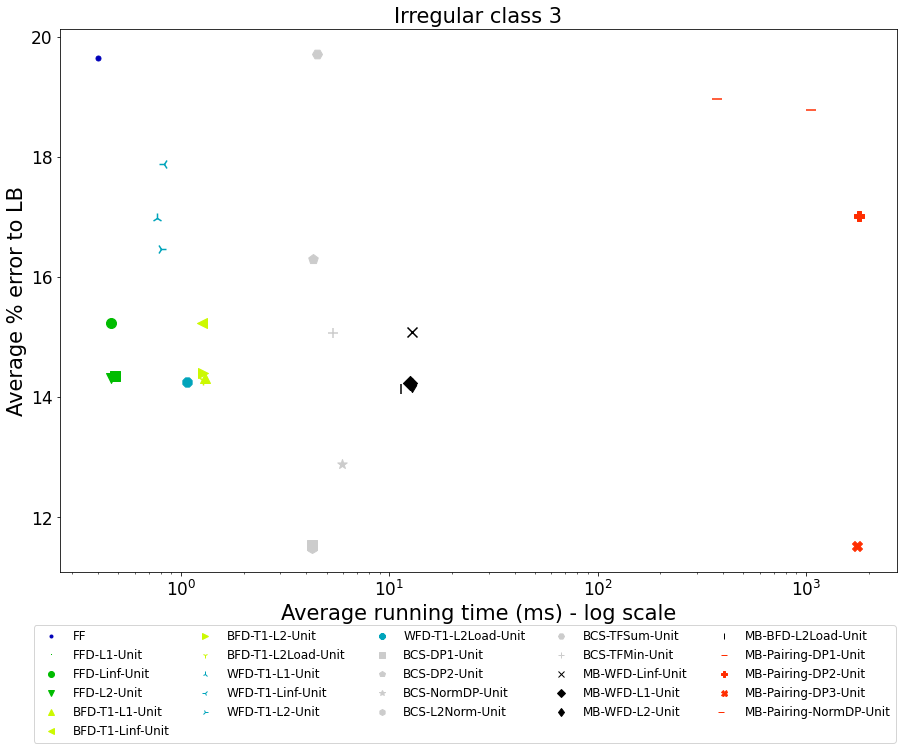

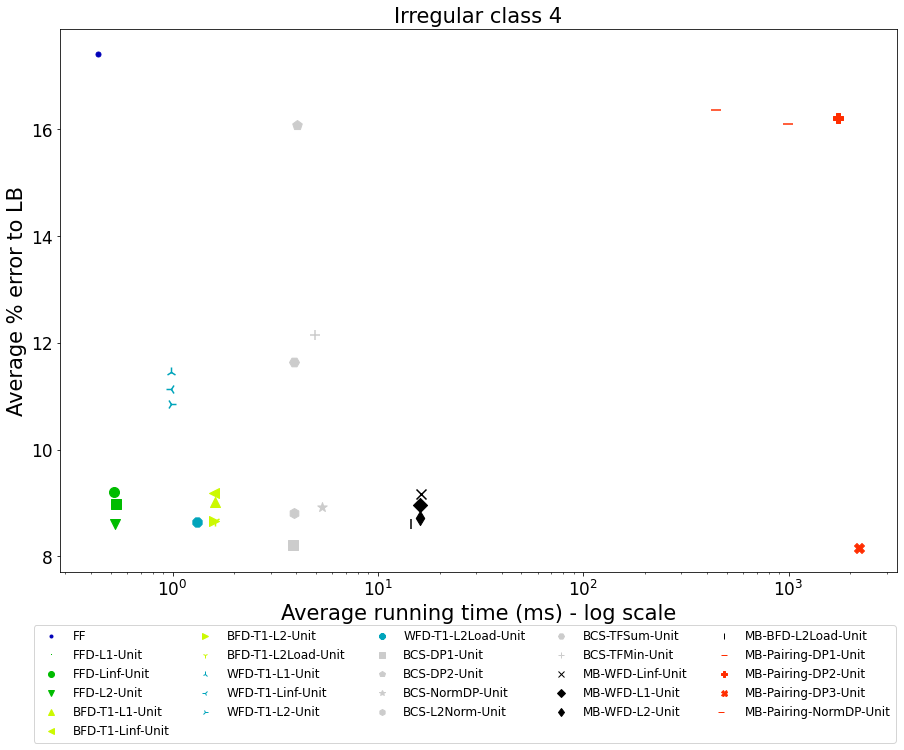

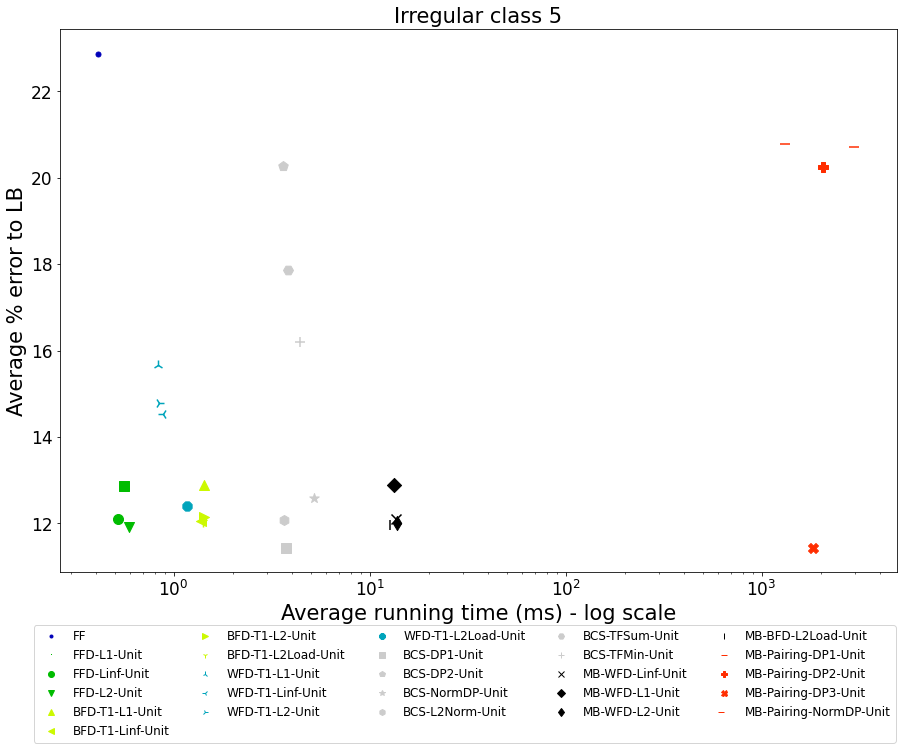

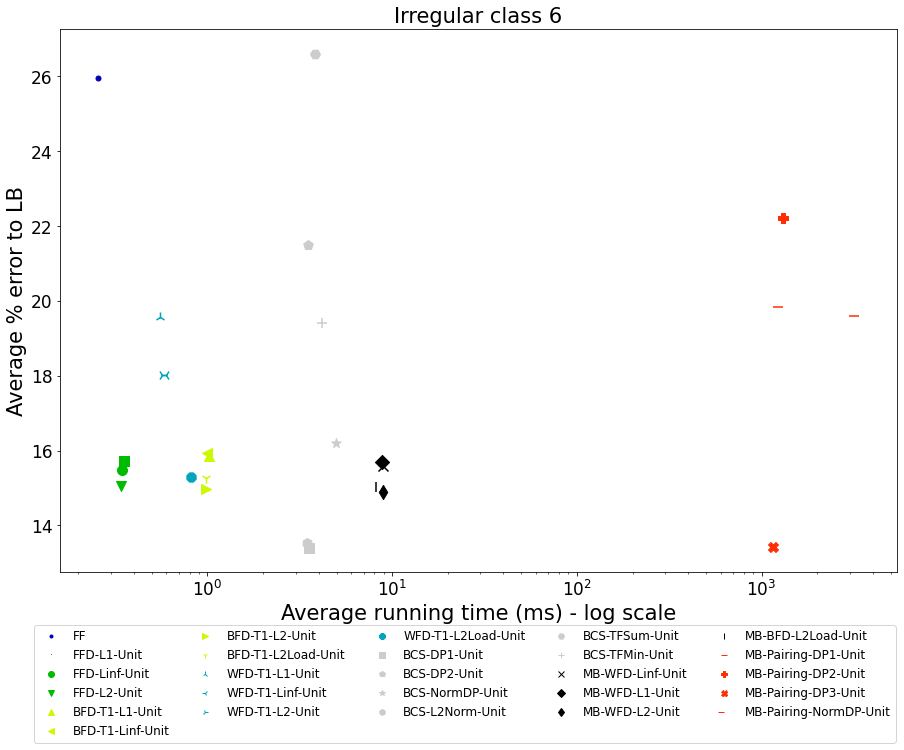

In [31]:
for c in range(1,7):
    fname = proj_path / f"plots/all_classes/unit_I{c}.pdf"
    plot_summary_family(unit_results_I[1].loc[str(c)], unit_results_I[0].loc[str(c)], alg_names_unit,
            f"Irregular class {c}", "Average running time (ms) - log scale", "Average % error to LB",
            log_scale=True, filename=fname,
            simplify_dict=False,
            bbox_anchor_y=-0.12)

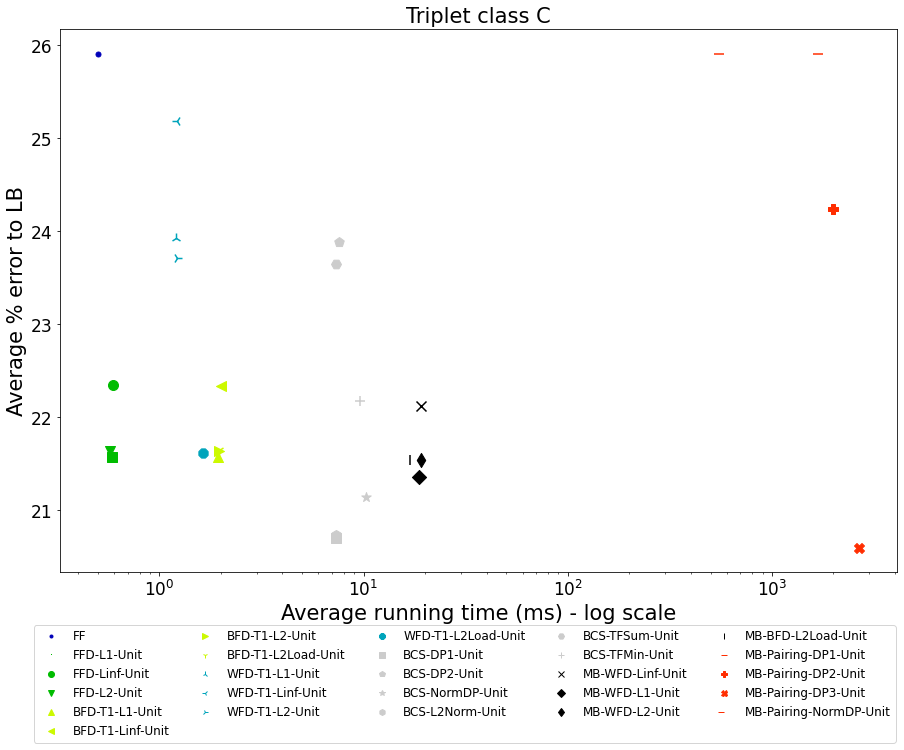

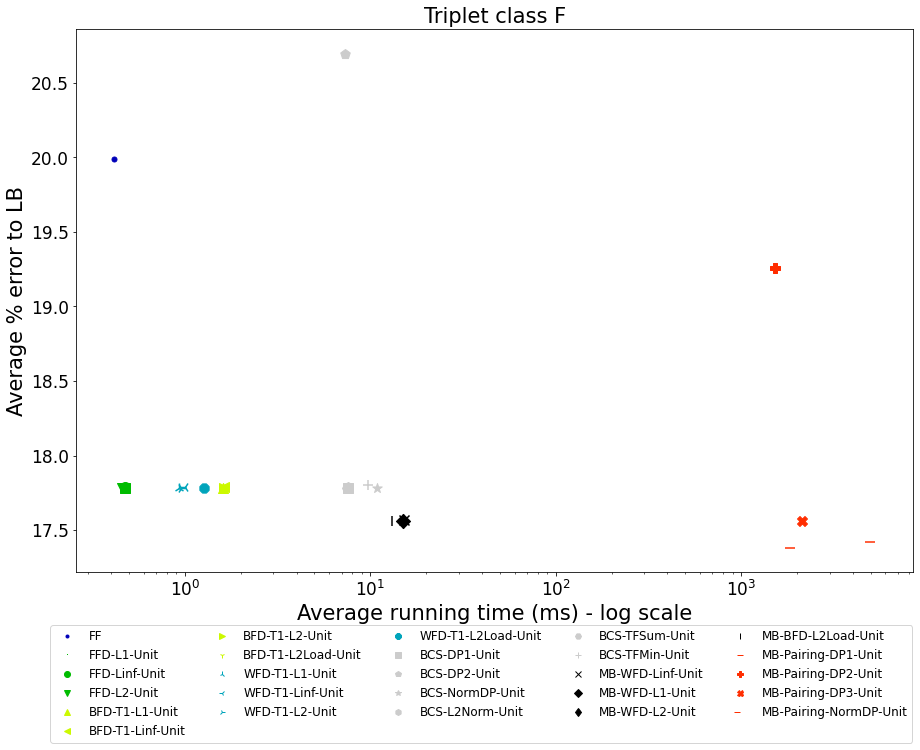

In [32]:
for c in ["C", "F"]:
    fname = proj_path / f"plots/all_classes/unit_T{c}.pdf"
    plot_summary_family(unit_results_T[1].loc[str(c)], unit_results_T[0].loc[str(c)], alg_names_unit,
            f"Triplet class {c}", "Average running time (ms) - log scale", "Average % error to LB",
            log_scale=True, filename=fname,
            simplify_dict=False,
            bbox_anchor_y=-0.12)

## Plot selected classes only
### Class P5

In [62]:
idxP5 = unit_results_P[0].loc["5"][alg_names_unit].mean().sort_values().head(15).index

In [ ]:
unit_results_P[0].loc["5"][idxP5].mean()

In [ ]:
unit_results_P[1].loc["5",500,:][idxP5].describe()

In [ ]:
alg_unit_P5 = alg_names_unit.copy()
alg_unit_P5.remove('BCS-TFSum-Unit') # Removed because greatly outperformed by all others
fname = proj_path / "plots/algos_unit_P5.pdf"
plot_summary_family(unit_results_P[1].loc["5"], unit_results_P[0].loc["5"], alg_unit_P5,
            "", "Average running time (ms) - log scale", "Average % error to LB",
            log_scale=True, filename=fname,
            bbox_anchor=(0.3, 0.12), ncols=2)

### Class P8

In [64]:
idxP8 = unit_results_P[0].loc["8"][alg_names_unit].mean().sort_values().head(15).index

In [ ]:
unit_results_P[0].loc["8"][idxP8].mean()

In [ ]:
unit_results_P[1].loc["8",500,:][idxP8].describe()

In [ ]:
fname = proj_path / "plots/algos_unit_P8.pdf"
plot_summary_family(unit_results_P[1].loc["8"], unit_results_P[0].loc["8"], alg_names_unit,
            "", "Average running time (ms) - log scale", "Average % error to LB",
            log_scale=True, filename=fname,
            bbox_anchor=(0.64, 0.64), ncols=3)
####### legend VOLUNTARILY out of bound here BUT correctly placed in the output PDF

### Class I5

In [66]:
idxI5 = unit_results_I[0].loc["5"][alg_names_unit].mean().sort_values().head(15).index

In [ ]:
unit_results_I[0].loc["5"][idxI5].mean()

In [ ]:
unit_results_I[1].loc["5",500,:][idxI5].describe()

In [ ]:
fname = proj_path / "plots/algos_unit_I5.pdf"
plot_summary_family(unit_results_I[1].loc["5"], unit_results_I[0].loc["5"], alg_names_unit,
            "", "Average unning time (ms) - log scale", "Average % error to LB",
            log_scale=True, filename=fname,
            bbox_anchor=(0.58, 0.54), ncols=2)
           ####### legend VOLUNTARILY out of bound here BUT correctly placed in the output PDF

### Class TF

In [68]:
idxTF = unit_results_T[0].loc["F"][alg_names_unit].mean().sort_values().head(15).index

In [ ]:
unit_results_T[0].loc["F"][idxTF].mean()

In [ ]:
unit_results_T[1].loc["F",501,:][idxTF].describe()

In [ ]:
fname = proj_path / "plots/algos_unit_TF.pdf"
plot_summary_family(unit_results_T[1].loc["F"], unit_results_T[0].loc["F"], alg_names_unit,
            "", "Average running time (ms) - log scale", "Average % error to LB",
            log_scale=True, filename=fname,
            bbox_anchor=(0.64, 0.64), ncols=3)
####### legend VOLUNTARILY out of bound here BUT correctly placed in the output PDF

### Count avg items per bin in a class

In [ ]:
P5 = df_P[df_P['class'] == '5'].index
(df_P.iloc[P5]['n'] / df_P.iloc[P5]['LB_or_OPT']).describe()

In [ ]:
P8 = df_P[df_P['class'] == '8'].index
(df_P.iloc[P8]['n'] / df_P.iloc[P8]['LB_or_OPT']).describe()

In [ ]:
I5 = df_I[df_I['class'] == '5'].index
(df_I.iloc[I5]['n'] / df_I.iloc[I5]['LB_or_OPT']).describe()

## Compare two algorithms together

In [ ]:
def my_sup(x):
    return x[x > 0].count()

def my_eq(x):
    return x[x == 0].count()

def my_low(x):
    return x[x < 0].count()

def make_diff(df, list1, list2):
    a = df[list1]
    b = df[list2]
    b.columns = a.columns
    df_diff = (a - b).agg(['mean', 'std', my_sup, my_eq, my_low])
    return df_diff

def make_all_diff(list1, list2):
    diff_P = make_diff(big_df_P, list1, list2)
    diff_I = make_diff(big_df_I, list1, list2)
    diff_T = make_diff(big_df_T, list1, list2)
    diff_df = pd.concat([diff_P, diff_I, diff_T], axis=1)
    diff_df.columns = ["diff_P", "diff_I", "diff_T"]
    return diff_df

# When comparing algo A with algo B
# Mean is negative when algo A is better than B
# my_sup counts when sol of A is worse than B
# my_low counts when sol of A is better than B

In [ ]:
df_diff = make_all_diff(["FFD-SumSq-Unit"], ["BFD-T1-SumSq-Unit"])
df_diff

In [ ]:
df_diff = make_all_diff(["FFD-SumSq-Unit"], ["WFD-T1-SumSqLoad-Unit"])
df_diff

In [ ]:
df_diff = make_all_diff(["FFD-SumSq-Unit"], ["BCS-DP1-Unit"])
df_diff

In [ ]:
df_diff = make_all_diff(["FFD-SumSq-Unit"], ["BIM-BS-DP3-Unit"])
df_diff

In [ ]:
df_diff = make_all_diff(["BCS-DP1-Unit"], ["BIM-BS-DP3-Unit"])
df_diff

In [ ]:
df_diff = make_all_diff(["BCS-DP1-Unit"], ["BCS-NormDP-Unit"])
df_diff

In [ ]:
# Find instances with identical result for the 4 algos
ddf = big_df_P
x = ddf[ddf["BCS-DP1-Unit"] == ddf["BIM-BS-DP3-Unit"]].index
y = ddf.loc[x][ddf["FFD-SumSq-Unit"].loc[x] == ddf["WFD-T1-SumSqLoad-Unit"].loc[x]].index
z = ddf.loc[y][ddf["FFD-SumSq-Unit"].loc[y] == ddf["BCS-DP1-Unit"].loc[y]]
z[["class", "n", "d", "FFD-SumSq-Unit", "WFD-T1-SumSqLoad-Unit", "BCS-DP1-Unit", "BIM-BS-DP3-Unit"]]

In [ ]:
# Find how many of these instances per class
aa = z[["class", "n", "d", "FFD-SumSq-Unit"]].groupby(by=["class", "n", "d"], as_index=True).count()

In [ ]:
for c in range(1,10):
    print("class", c)
    print(aa.loc[str(c)].sum())

## Check optimal solution found

In [33]:
def print_optimal_found(df, benchmark_name, algo_names, full=False):
    if benchmark_name == "P":
        l = range(1,10)
    elif benchmark_name == "I":
        l = range(1,7)
    else: # "T"
        l = ["C", "F"]
        
    sum1 = 0
    sum2 = 0
        
    for c in l:
        sub_df = df[df['class'] == str(c)]
        best_sol = sub_df[algo_names].min(axis=1)
        proved_opt = (sub_df["LB"] == best_sol).sum()
        found_opt = (sub_df["LB_or_OPT"] == best_sol).sum()
        sum1+=proved_opt
        sum2+=found_opt
        
        if full:
            print(f"Class {c}: {proved_opt} proved optimality (sol = LB) over {sub_df.shape[0]} instances")
            print(f"\t {found_opt} optimal solution found")
    
    print(f"Total: {sum1} proved optimality over {df.shape[0]} instances")
    print(f"Total: {sum2} optimal found over {df.shape[0]} instances")

In [34]:
centric_unit = [x for x in alg_names_unit if not "MB-" in x]

In [35]:
# With only the iten-centric and bin-centric algos with Unit weights
print("--- For Panigrahy instances ---")
print_optimal_found(df_P, "P", centric_unit)
print("\n--- For Irregular instances ---")
print_optimal_found(df_I, "I", centric_unit)
print("\n--- For Triplet instances ---")
print_optimal_found(df_T, "T", centric_unit)

--- For Panigrahy instances ---
Total: 597 proved optimality over 1620 instances
Total: 889 optimal found over 1620 instances

--- For Irregular instances ---
Total: 84 proved optimality over 1080 instances
Total: 197 optimal found over 1080 instances

--- For Triplet instances ---
Total: 0 proved optimality over 240 instances
Total: 0 optimal found over 240 instances


In [36]:
# With all algos with Unit weights
print("--- For Panigrahy instances ---")
print_optimal_found(df_P, "P", alg_names_unit)
print("\n--- For Irregular instances ---")
print_optimal_found(df_I, "I", alg_names_unit)
print("\n--- For Triplet instances ---")
print_optimal_found(df_T, "T", alg_names_unit)

--- For Panigrahy instances ---
Total: 601 proved optimality over 1620 instances
Total: 893 optimal found over 1620 instances

--- For Irregular instances ---
Total: 87 proved optimality over 1080 instances
Total: 200 optimal found over 1080 instances

--- For Triplet instances ---
Total: 0 proved optimality over 240 instances
Total: 0 optimal found over 240 instances


In [37]:
centric_all = [x for x in all_algos if not "MB-" in x]
print(len(centric_all))

275


In [38]:
# With only item-centric and bin-centric algos with all weights
print("--- For Panigrahy instances ---")
print_optimal_found(df_P, "P", centric_all)
print("\n--- For Irregular instances ---")
print_optimal_found(df_I, "I", centric_all)
print("\n--- For Triplet instances ---")
print_optimal_found(df_T, "T", centric_all)

--- For Panigrahy instances ---
Total: 637 proved optimality over 1620 instances
Total: 985 optimal found over 1620 instances

--- For Irregular instances ---
Total: 113 proved optimality over 1080 instances
Total: 257 optimal found over 1080 instances

--- For Triplet instances ---
Total: 0 proved optimality over 240 instances
Total: 0 optimal found over 240 instances


In [39]:
# With all algos and all weights
print("--- For Panigrahy instances ---")
print_optimal_found(df_P, "P", all_algos)
print("\n--- For Irregular instances ---")
print_optimal_found(df_I, "I", all_algos)
print("\n--- For Triplet instances ---")
print_optimal_found(df_T, "T", all_algos)

--- For Panigrahy instances ---
Total: 643 proved optimality over 1620 instances
Total: 992 optimal found over 1620 instances

--- For Irregular instances ---
Total: 116 proved optimality over 1080 instances
Total: 260 optimal found over 1080 instances

--- For Triplet instances ---
Total: 0 proved optimality over 240 instances
Total: 0 optimal found over 240 instances


# Comparison with Avg weight
## Only with selected algorithms from Unit weights

In [77]:
selected_unit = [
    "FFD-L2-Unit",
    "BFD-T1-L2-Unit",
    "WFD-T1-L2Load-Unit",
    "BCS-DP1-Unit",
    "MB-WFD-L2-Unit",
    "MB-Pairing-DP3-Unit",
]

In [78]:
selected_algos_avg = [
    "FFD-L2-Unit",
    "FFD-L2-Avg",
    "FFD-L2-Avg-Dyn",
    
    "BFD-T1-L2-Unit",
    "BFD-T1-L2-Avg",
    "BFD-T1-L2-Avg-Dyn",
    
    "WFD-T1-L2Load-Unit",
    "WFD-T1-L2Load-Avg",
    "WFD-T1-L2Load-Avg-Dyn",
    
    "BCS-DP1-Unit",
    "BCS-DP1-Avg",
    "BCS-DP1-Avg-Dyn",
    
    "MB-WFD-L2-Unit",
    "MB-WFD-L2-Avg",
    "MB-WFD-L2-Avg-Dyn",
    
    "MB-Pairing-DP3-Unit",
    "MB-Pairing-DP3-Avg",
    "MB-Pairing-DP3-Avg-Dyn",
]

In [79]:
# Computing aggregated results once and for all
# For all Centric + Multibin algos
big_results_P = get_results(df_P, all_algos, ['class', 'n', 'd'], group_as_index=True)
big_results_I = get_results(df_I, all_algos, ['class', 'n', 'd'], group_as_index=True)
big_results_T = get_results(df_T, all_algos, ['class', 'n', 'd'], group_as_index=True)
# results contains: eps, time, diff, diff_best, best, match_LB

## Plots with Avg weights for all classes

In [ ]:
for c in range(1,10):
    fname = proj_path / f"plots/all_classes/avg_P{c}.pdf"
    plot_summary_family(big_results_P[1].loc[str(c)], big_results_P[0].loc[str(c)], selected_algos_avg,
            f"Panigrahy class {c}", "Average running time (ms) - log scale", "Average % error to LB",
            log_scale=True, filename=fname,
            bbox_anchor_y=-0.07, ncols=5)

In [ ]:
for c in range(1,7):
    fname = proj_path / f"plots/all_classes/avg_I{c}.pdf"
    plot_summary_family(big_results_I[1].loc[str(c)], big_results_I[0].loc[str(c)], selected_algos_avg,
            f"Irregular class {c}", "Average running time (ms) - log scale", "Average % error to LB",
            log_scale=True, filename=fname,
            bbox_anchor_y=-0.07, ncols=5)

In [ ]:
for c in ["F", "C"]:
    fname = proj_path / f"plots/all_classes/avg_T{c}.pdf"
    plot_summary_family(big_results_T[1].loc[str(c)], big_results_T[0].loc[str(c)], selected_algos_avg,
            f"Triplet class {c}", "Average running time (ms) - log scale", "Average % error to LB",
            log_scale=True, filename=fname,
            bbox_anchor_y=-0.07, ncols=5)

In [ ]:
print("--- Results averaged over ALL classes  ---")
for alg in selected_unit:
    print(alg)
    alg_avg = alg.replace("Unit", "Avg")
    alg_dyn = alg.replace("Unit", "Avg-Dyn")
    a = big_results_P[0][alg].mean()
    b = big_results_P[0][alg_avg].mean()
    c = big_results_P[0][alg_dyn].mean()
    print(f"  Unit VS Avg: eps diff {a - b:.2f} % {b / a:.2f}")
    print(f"  Unit VS Dyn: eps diff {a - c:.2f} % {c / a:.2f}\n")
    
    ta = big_results_P[1][alg].mean()
    tb = big_results_P[1][alg_avg].mean()
    tc = big_results_P[1][alg_dyn].mean()
    print(f"  Unit VS Avg: time diff {ta - tb:.2f} % {tb / ta:.2f}")
    print(f"  Unit VS Dyn: time diff {ta - tc:.2f} % {tc / ta:.2f}\n")

### Selected class P8

In [ ]:
big_results_P[0].loc['8'][selected_algos_avg].mean()

In [ ]:
big_results_P[1].loc['8'][selected_algos_avg].mean()

In [ ]:
big_results_P[1].loc['8'][selected_algos_avg].max()

In [ ]:
fname = proj_path / "plots/avg_weights_P8.pdf"
plot_summary_family(big_results_P[1].loc["8"], big_results_P[0].loc["8"], selected_algos_avg,
            "", "Running time (ms) - log scale", "% error to LB",
            log_scale=True, filename=fname,
            bbox_anchor=(0.71, 0.13),
            ncols=2)

# Comparison with all algos and all weights

In [83]:
def add_meta_algos(df, alg_names):
    centric = [x for x in alg_names if not "MB-" in x]
    
    time_cols_centric = [i+'_timems' for i in centric]
    df['meta-centric'] = df[centric].min(axis=1)
    df['meta-centric_timems'] = df[time_cols_centric].sum(axis=1)
    
    time_cols_all = [i+'_timems' for i in alg_names]
    df['meta-all'] = df[alg_names].min(axis=1)
    df['meta-all_timems'] = df[time_cols_all].sum(axis=1)

In [84]:
add_meta_algos(df_P, all_algos)
add_meta_algos(df_I, all_algos)
add_meta_algos(df_T, all_algos)

In [85]:
algos_with_meta = all_algos + ["meta-centric", "meta-all"]

In [86]:
# Computing aggregated results once and for all
# For all Centric + Multibin algos
big_results_P = get_results(df_P, algos_with_meta, ['class', 'n', 'd'], group_as_index=True)
big_results_I = get_results(df_I, algos_with_meta, ['class', 'n', 'd'], group_as_index=True)
big_results_T = get_results(df_T, algos_with_meta, ['class', 'n', 'd'], group_as_index=True)

# results contains: eps, time, diff, diff_best, best, match_LB

In [ ]:
it = [x for x in all_algos if "MB-" not in x and "BCS" not in x]
bi = [x for x in all_algos if "BCS" in x]
mb = [x for x in all_algos if "MB-" in x]

In [ ]:
print(len(all_algos), len(it), len(bi), len(mb))

In [ ]:
df = df_P
algs = all_algos

nb_instances = df.shape[0]
sub_list = algs.copy()
new_list = []
for i in range(len(algs)):
    algo_test = sub_list.pop(0)
    new_list.append(algo_test)
    # Find algos performing equally to algo_test
    counts = df[sub_list].apply(lambda x: x == df[algo_test]).sum()
    l = list(counts[counts == nb_instances].index)
    if (len(l) != 0):
        # If some are found, remove them from the sub_list
        print(f"{algo_test} identical to: {l}")
        sub_list = [x for x in sub_list if not x in l]
    if (len(sub_list) == 0):
        break
# Sub_list contains 'unique' algos
print(f"There are {len(new_list)} 'unique' algos")

In [87]:
to_remove = ['BCS-NormDP-Avg-Bin', 'MB-Pairing-DP1-UtilRatio',
             'MB-Pairing-NormDP-Avg', 'MB-Pairing-NormDP-Avg-Dyn',
             'MB-Pairing-DP3-UtilRatio',
             'MB-WFD-Linf-UtilRatio',
             'MB-WFD-L1-UtilRatio',
             'MB-WFD-L2-UtilRatio',
             'MB-BFD-L2Load-UtilRatio'
            ]
new_algos = [x for x in all_algos if not x in to_remove]
#new_algos = [x for x in algos_with_meta if not x in to_remove]


In [88]:
to_remove = ["BF-", "WF-"] # Need the dash after BF and WF to keep BFD/WFD
filtered_algos = filter_algo_list(new_algos, to_remove)

In [89]:
def create_selected_list(eps, fam_dict, with_meta=False):
    l = []
    for fam, fam_list in fam_dict.items():
        if fam == "FF":
            l.append("FF")
        else:
            eps_avg = eps[fam_list].mean()
            eps_avg.sort_values(ascending=True, inplace=True)
            l.extend(eps_avg.index[:1])
    
    if with_meta:
        l = l + ["meta-centric", "meta-all"]
    return l

In [90]:
fam_dict = create_family_dict(filtered_algos)
#fam_dict = create_family_dict(new_algos)

In [ ]:
for c in range(1,10):
    fname = proj_path / f"plots/all_classes/all_weights_P{c}.pdf"
    sel_algos = create_selected_list(big_results_P[0].loc[str(c)], fam_dict, with_meta=True)
    plot_summary_family(big_results_P[1].loc[str(c)], big_results_P[0].loc[str(c)], sel_algos,
            f"Panigrahy class {c}", "Average running time (ms) - log scale", "Average % error to LB",
            log_scale=True, filename=fname,
            simplify_dict=True, show_legend=True,
            bbox_anchor=(0.5,-0.15), ncols=4)

In [ ]:
for c in range(1,7):
    fname = proj_path / f"plots/all_classes/all_weights_I{c}.pdf"
    sel_algos = create_selected_list(big_results_I[0].loc[str(c)], fam_dict, with_meta=True)
    plot_summary_family(big_results_I[1].loc[str(c)], big_results_I[0].loc[str(c)], sel_algos,
            f"Irregular class {c}", "Average running time (ms) - log scale", "Average % error to LB",
            log_scale=True, filename=fname,
            simplify_dict=True, show_legend=True,
            bbox_anchor=(0.5,-0.15), ncols=4)

In [ ]:
for c in ["C", "F"]:
    fname = proj_path / f"plots/all_classes/all_weights_T{c}.pdf"
    sel_algos = create_selected_list(big_results_T[0].loc[str(c)], fam_dict, with_meta=True)
    plot_summary_family(big_results_T[1].loc[str(c)], big_results_T[0].loc[str(c)], sel_algos,
            f"Triplet class {c}", "Average running time (ms) - log scale", "Average % error to LB",
            log_scale=True, filename=None,
            simplify_dict=True, show_legend=True,
            bbox_anchor=(0.5,-0.15), ncols=4)

## Plots of selected classes
### Class P5

In [94]:
sel_algos_P5 = create_selected_list(big_results_P[0].loc["5"], fam_dict, with_meta=True)

In [ ]:
eps_P5 = big_results_P[0].loc["5"]
time_P5 = big_results_P[1].loc["5",500,:]
idx_P5 = eps_P5[sel_algos_P5].mean().sort_values().index
for alg in idx_P5:
    print(f"{alg}\n\teps: {eps_P5[alg].mean():.2f}\n\ttime: {time_P5[alg].mean():.2f}\t{time_P5[alg].max()}")

In [ ]:
fname = proj_path / "plots/all_weights_P5.pdf"
plot_summary_family(big_results_P[1].loc["5"], big_results_P[0].loc["5"], sel_algos_P5,
            "", "Average running time (ms) - log scale", "Average % error to LB",
            log_scale=True, filename=fname,
            simplify_dict=True, show_legend=True,
            ncols = 2, bbox_anchor=(0.70, 0.57),
            legend_size=FONT_SIZE-6
            )

### Class P8

In [96]:
sel_algos_P8 = create_selected_list(big_results_P[0].loc["8"], fam_dict, with_meta=True)

In [ ]:
eps_P8 = big_results_P[0].loc["8"]
time_P8 = big_results_P[1].loc["8",500,:]
idx_P8 = eps_P8[sel_algos_P8].mean().sort_values().index
for alg in idx_P8:
    print(f"{alg}\n\teps: {eps_P8[alg].mean():.2f}\n\ttime: {time_P8[alg].mean():.2f}\t{time_P8[alg].max()}")

In [ ]:
fname = proj_path / "plots/all_weights_P8.pdf"
plot_summary_family(big_results_P[1].loc["8"], big_results_P[0].loc["8"], sel_algos_P8,
            "", "Average running time (ms) - log scale", "Average % error to LB",
            log_scale=True, filename=fname,
            simplify_dict=True, show_legend=True,
            ncols = 2, bbox_anchor=(0.675, 0.54)
        ####### legend VOLUNTARILY out of bound here BUT correctly placed in the output PDF
            )

### class I5

In [98]:
sel_algos_I5 = create_selected_list(big_results_I[0].loc["5"], fam_dict, with_meta=True)

In [ ]:
eps_I5 = big_results_I[0].loc["5"]
time_I5 = big_results_I[1].loc["5",500,:]
idx_I5 = eps_I5[sel_algos_I5].mean().sort_values().index
for alg in idx_I5:
    print(f"{alg}\n\teps: {eps_I5[alg].mean():.2f}\n\ttime: {time_I5[alg].mean():.2f}\t{time_I5[alg].max()}")

In [ ]:
fname = proj_path / "plots/all_weights_I5.pdf"
plot_summary_family(big_results_I[1].loc["5"], big_results_I[0].loc["5"], sel_algos_I5,
            "", "Average running time (ms) - log scale", "Average % error to LB",
            log_scale=True, filename=fname,
            simplify_dict=True, show_legend=True,
            ncols = 2, bbox_anchor=(0.67, 0.54)
            ####### legend VOLUNTARILY out of bound here BUT correctly placed in the output PDF
            )

### class TF

In [100]:
sel_algos_TF = create_selected_list(big_results_T[0].loc["F"], fam_dict, with_meta=True)

In [ ]:
eps_TF = big_results_T[0].loc["F"]
time_TF = big_results_T[1].loc["F",501,:]
idx_TF = eps_TF[sel_algos_TF].mean().sort_values().index
for alg in idx_TF:
    print(f"{alg}\n\teps: {eps_TF[alg].mean():.2f}\n\ttime: {time_TF[alg].mean():.2f}\t{time_TF[alg].max()}")

In [ ]:
fname = proj_path / "plots/all_weights_TF.pdf"
plot_summary_family(big_results_T[1].loc["F"], big_results_T[0].loc["F"], sel_algos_TF,
            "", "Average running time (ms) - log scale", "Average % error to LB",
            log_scale=True, filename=fname,
            simplify_dict=True, show_legend=True,
            #ncols = 2, bbox_anchor=(0.68, 0.52)
            ncols = 2, bbox_anchor=(0.34, 0.13)
            )

## Check optimal found with all algos and weights

In [102]:
print("--- For Panigrahy instances ---")
print_optimal_found(df_P, "P", all_algos)
print("\n--- For Irregular instances ---")
print_optimal_found(df_I, "I", all_algos)
print("\n--- For Triplet instances ---")
print_optimal_found(df_T, "T", all_algos)

--- For Panigrahy instances ---
Total: 643 proved optimality over 1620 instances
Total: 992 optimal found over 1620 instances

--- For Irregular instances ---
Total: 116 proved optimality over 1080 instances
Total: 260 optimal found over 1080 instances

--- For Triplet instances ---
Total: 0 proved optimality over 240 instances
Total: 0 optimal found over 240 instances


In [103]:
centric_algos = [x for x in all_algos if "MB-" not in x]

In [104]:
print("--- For Panigrahy instances ---")
print_optimal_found(df_P, "P", centric_algos)
print("\n--- For Irregular instances ---")
print_optimal_found(df_I, "I", centric_algos)
print("\n--- For Triplet instances ---")
print_optimal_found(df_T, "T", centric_algos)

--- For Panigrahy instances ---
Total: 637 proved optimality over 1620 instances
Total: 985 optimal found over 1620 instances

--- For Irregular instances ---
Total: 113 proved optimality over 1080 instances
Total: 257 optimal found over 1080 instances

--- For Triplet instances ---
Total: 0 proved optimality over 240 instances
Total: 0 optimal found over 240 instances


## Plots error as function of n

In [105]:
def plot_n_eps(x_data, y_data, c, alg_list,
               stitle, xlabel, ylabel,
               **kwargs):
    
    # kwargs parameters
    if "bbox_anchor" in kwargs:
        bbox_anchor = kwargs["bbox_anchor"]
    else:
        bbox_anchor = (kwargs.get("bbox_anchor_x", 0.5), kwargs.get("bbox_anchor_y", -0.12))
    
    ncols = kwargs.get("ncols", 5)
    
    #fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True)
    fig = plt.figure(figsize=(15,8))
    gs = fig.add_gridspec(3, 1)
    (ax1, ax2, ax3) = gs.subplots(sharex=True, sharey=True)
    
    # To sort the algos by FFD, BFD, WFD, BCS, MB order
    alg_list.sort(key=lambda x: get_score(x))
    
    #fam_colors = family_color_dict
    #color_list = create_alg_colors(alg_list, fam_colors, family_list)
    color_list = create_small_colors(len(alg_list))
    seed(SEED_NUMBER+1)
    shuffle(color_list)
    
    y1 = y_data.loc[c, :, 3]
    y2 = y_data.loc[c, :, 5]
    y3 = y_data.loc[c, :, 10]

    for i in range(len(alg_list)):
        alg = alg_list[i]
        #plt.plot(x_data, y_data[alg], '.:', c=color_list[i], label=alg, linewidth=2, markersize=15)
        ax1.plot(x_data, y1[alg], '.:', c=color_list[i], label=alg, linewidth=2, markersize=15)
        ax2.plot(x_data, y2[alg], '.:', c=color_list[i], label=alg, linewidth=2, markersize=15)
        ax3.plot(x_data, y3[alg], '.:', c=color_list[i], label=alg, linewidth=2, markersize=15)

    #plt.legend(numpoints=1, loc='lower center', ncol=4, bbox_to_anchor=(.5, -.3))
    
    #simple_names = [dict_simple_names.get(x,x) for x in alg_list]
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_list]
    fig.legend(markers, alg_list, numpoints=1, loc='lower center', fontsize=FONT_SIZE-4,
               ncol=ncols, bbox_to_anchor=bbox_anchor)

    plt.xticks(x_data)
    #fig.suptitle(stitle, fontsize=FONT_SIZE)
    plt.xlabel(xlabel, fontsize=FONT_SIZE)
    #plt.ylabel(ylabel, fontsize=FONT_SIZE)
    ax2.set_ylabel(ylabel, fontsize=FONT_SIZE+3)
    
    ax1.set_title(stitle + ", d=3", fontsize=FONT_SIZE)
    ax2.set_title("d=5", fontsize=FONT_SIZE-2)
    ax3.set_title("d=10", fontsize=FONT_SIZE-2)
    
    ax1.tick_params(axis="y", labelsize=FONT_SIZE-3)
    ax2.tick_params(axis="y", labelsize=FONT_SIZE-3)
    ax3.tick_params(axis="both", labelsize=FONT_SIZE-3)
    
    if kwargs.get("log_scale_x", False):
        plt.xscale('log')
    if kwargs.get("log_scale_y", False):
        plt.yscale('log')
    
    plt.show()
    
    filename = kwargs.get("filename", None)
    if filename:
        fig.savefig(filename, bbox_inches='tight')

In [106]:
simple_fam_dict = create_simple_family_dict(filtered_algos)
del simple_fam_dict["FF"]

In [ ]:
for c in range(1,10):
    fname = proj_path / f"plots/all_lines/lines_P{c}.pdf"
    sel_algos_test = create_selected_list(big_results_P[0].loc[str(c)], simple_fam_dict, with_meta=False)
    plot_n_eps([20, 40, 60, 120, 250, 500], big_results_P[0], str(c), sel_algos_test,
           f"Class {c} of Panigrahy", "Number of items", "% error",
           ncols=3, bbox_anchor=(0.5, -0.04), filename=fname)

In [ ]:
for c in range(1,7):
    fname = proj_path / f"plots/all_lines/lines_I{c}.pdf"
    sel_algos_test = create_selected_list(big_results_I[0].loc[str(c)], simple_fam_dict, with_meta=False)
    plot_n_eps([20, 40, 60, 120, 250, 500], big_results_I[0], str(c), sel_algos_test,
           f"Class {c} of Irregular", "Number of items", "% error",
           ncols=3, bbox_anchor=(0.5, -0.04), filename=fname)

In [ ]:
for c in ["F", "C"]:
    fname = proj_path / f"plots/all_lines/lines_T{c}.pdf"
    sel_algos_test = create_selected_list(big_results_T[0].loc[str(c)], simple_fam_dict, with_meta=False)
    plot_n_eps([60, 120, 249, 501], big_results_T[0], str(c), sel_algos_test,
           f"Class {c} of Triplet", "Number of items", "% error",
           ncols=3, bbox_anchor=(0.5, -0.04), filename=fname)

In [39]:
big_results_P[1].loc['5', 500, :]

,FF,FFD-L1-Unit,FFD-L1-Avg,FFD-L1-Expo,FFD-L1-RecipAvg,FFD-Linf-Unit,FFD-Linf-Avg,FFD-Linf-Expo,FFD-Linf-RecipAvg,FFD-L2-Unit,...,MB-BFD-L2Load-Unit,MB-BFD-L2Load-Avg,MB-BFD-L2Load-Expo,MB-BFD-L2Load-RecipAvg,MB-BFD-L2Load-Avg-Dyn,MB-BFD-L2Load-Expo-Dyn,MB-BFD-L2Load-RecipAvg-Dyn,MB-BFD-L2Load-UtilRatio,meta-centric,meta-all
d,,,,,,,,,,,,,,,,,,,,,
3,0.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,...,3.4,3.8,3.4,3.8,25.9,24.4,31.6,25.9,2338.1,50814.5
5,0.0,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,4.2,4.4,4.2,4.2,46.7,48.2,48.8,46.7,3145.1,71388.1
10,0.2,0.4,0.4,0.4,0.4,0.4,0.6,0.4,0.4,0.4,...,5.6,5.9,5.5,6.0,78.5,90.9,91.6,78.2,5371.9,129235.6


# Compare several algorithms

In [ ]:
def my_sup(x):
    return x[x > 0].count()

def my_eq(x):
    return x[x == 0].count()

def my_low(x):
    return x[x < 0].count()

def make_diff(df, list1, list2):
    a = df[list1]
    b = df[list2]
    b.columns = a.columns
    df_diff = (a - b).agg(['mean', 'std', my_sup, my_eq, my_low])
    return df_diff

def make_diff_classes(algo1, algo2, base_df, bench_name):
    if bench_name == "P":
        l = range(1,10)
    elif bench_name == "I":
        l = range(1,7)
    else:
        l = ["C", "F"]
        
    dfs = []
    cols = []
    for c in l:
        dfs.append(make_diff(base_df[base_df["class"] ==str(c)], [algo1], [algo2]))
        cols.append(f"{algo1}_{c}")
    
    diff_df = pd.concat(dfs, axis=1)
    diff_df.columns = cols
    return diff_df

# When comparing algo A with algo B
# Mean is negative when algo A is better than B
# my_sup counts when sol of A is worse than B
# my_low counts when sol of A is better than B

In [ ]:
alA = "FFD-Sum-Avg"
alB = "FFD-SumSq-Avg"
df_diff = make_diff_classes(alA, alB, big_df_P, "P")
print(df_diff)

In [ ]:
df_diff = make_diff_classes(alA, alB, big_df_I, "I")
print(df_diff)

In [ ]:
df_diff = make_diff_classes("BCS-DP1-Expo", "BCS-DP2-Avg-Dyn", big_df_P, "P")
print(df_diff)

In [ ]:
df_diff = make_diff_classes("BIM-BS-DP3-Avg", "BIM-BS-DP1-DivAvg-Dyn", big_df_T, "T")
print(df_diff)

In [ ]:
df_diff = make_diff_classes("FFD-Sum-Avg-Dyn", "WFD-T1-SumSqLoad-Avg-Dyn", big_df_P, "P")
print(df_diff)

In [ ]:
df_diff = make_diff(big_df_P, ["FFD-SumSq-Unit", "FFD-Sum-Unit"],["FFD-SumSq-Avg", "FFD-Sum-Avg"])
print(df_diff)

In [ ]:
df_diff = make_all_diff(["FFD-SumSq-Unit", "FFD-Sum-Unit"],
                        ["FFD-SumSq-Avg", "FFD-Sum-Avg"])
df_diff

In [ ]:
df_diff = make_all_diff(["FFD-SumSq-Unit"],
                        ["FFD-SumSq-Avg"])
df_diff

## For Latex tables

In [ ]:
def create_table_df(main_df, results, alg_names):
    sub_df = main_df[['class', 'n', 'd', 'best_sol']].copy()
    sub_df["best_opt"] = sub_df["best_sol"] == main_df["LB_or_OPT"]
    sub_df["best_eps"] = round(sub_df["best_sol"] / main_df["LB_or_OPT"] - 1, 3)*100

    avg_best = sub_df[['class', 'n', 'd', 'best_sol']].groupby(by=['class', 'n', 'd'], as_index=True).mean()
    opt_best = sub_df[['class', 'n', 'd', 'best_opt']].groupby(by=['class', 'n', 'd'], as_index=True).sum()
    eps_best = sub_df[['class', 'n', 'd', 'best_eps']].groupby(by=['class', 'n', 'd'], as_index=True).mean()

    eps, time, _, diff_best, _, match_LB = results
    time_best = time.sum(axis=1) # The cumulated time taken by all algorithms
    list_df = [avg_best, opt_best, eps_best, time_best]
    cols = ["avg_best", "opt_best", "eps_best", "time_best"]
    for alg in alg_names:
        list_df.append(eps[alg])
        list_df.append(diff_best[alg])
        list_df.append(match_LB[alg])
        list_df.append(time[alg])
        cols.extend([alg+"_eps", alg+"_diff", alg+"_opt", alg+"_time"])
        
    res_df = pd.concat(list_df, axis=1)
    res_df.columns = cols
    return res_df

In [ ]:
table_path = proj_path / "results/tables"
print(table_path)

def write_table(filename, s):
    with open(filename, 'w') as f:
        f.write(s)

### Tables for Unit weights

In [ ]:
def simple_name_unit(alg_name):
    v = alg_name.split('-')
    if len(v) < 2:
        return alg_name
    
    if 'T1' in alg_name or 'BS' in alg_name:
        return f"{v[0]}-{v[2]}"
    
    return f"{v[0]}-{v[1]}"

In [ ]:
def generate_table_unit(df, algo_list, class_range, n_range,
                       stitle, slabel):
    shead = "\\begin{landscape}\n\\begin{table}\n\\footnotesize\n\\centering\n\\caption{" + stitle + "}"
    shead+= "\label{" + slabel + "}\n"
    shead+= "\\begin{tabular}{|lrrr|rrr|" + "rrr|"*(len(algo_list)) + "}\n"
    shead+= "\\hline\n"
    shead+= " & & & & \multicolumn{3}{c|}{Combined best}"
    salgs = "\\rule{0pt}{.4cm}Class & n & d & Avg.Bins & \%err & Time & \#opt"
    for alg in algo_list:
        shead+= " & \multicolumn{3}{c|}{" + simple_name_unit(alg) + "}"
        salgs += " & \%err & Diff & Time"
    shead+= "\\\\\n" + salgs + "\\\\\n\hline\n"

    sbody = ""
    for c in class_range:
        cfirst = str(c)
        sbody+= cfirst
        for n in n_range:
            sbody+= "\\rule{0pt}{.6cm} & " + str(n)
            smid = " &"
            for d in [3, 5, 10]:
                avg_best = df.loc[cfirst,n,d]['avg_best']
                eps_best = df.loc[cfirst,n,d]['eps_best']
                opt_best = df.loc[cfirst,n,d]['opt_best']
                time_best = df.loc[cfirst,n,d]['time_best']
                smid+= f" {d} & {avg_best:.1f} & {eps_best:.1f} & {time_best:.1f} & {opt_best:.0f}"
                for alg in algo_list:
                    smid+= f" & {df.loc[cfirst,n,d][alg+'_eps']:.1f} & {df.loc[cfirst,n,d][alg+'_diff']:.1f}"
                    smid+= f" & {df.loc[cfirst,n,d][alg+'_time']:.1f}"
                sbody+= smid + "\\\\\n"
                smid = " & &"

        sbody+= "\multicolumn{4}{|c|}{\\rule{0pt}{.5cm}Summary over all instances}"
        sbody+= f" & {df.loc[cfirst]['eps_best'].mean():.1f} & {df.loc[cfirst]['time_best'].mean():.1f}"
        sbody+= f" & {df.loc[cfirst]['opt_best'].sum():.0f}"
        for alg in algo_list:
            sbody+= f" & {df.loc[cfirst][alg+'_eps'].mean():.1f} & {df.loc[cfirst][alg+'_diff'].mean():.1f}"
            sbody+= f" & {df.loc[cfirst][alg+'_time'].mean():.1f}"
        sbody+= "\\\\\n" + "\\hline\n"
        
    sfull = shead + sbody + "\end{tabular}\n\end{table}\n\end{landscape}"
    
    return sfull

In [ ]:
table_df_P = create_table_df(big_df_P, big_results_P, all_algos)
table_df_I = create_table_df(big_df_I, big_results_I, all_algos)
table_df_T = create_table_df(big_df_T, big_results_T, all_algos)
#table_df_Q = create_table_df(big_df_Q, big_results_Q, all_algos)

In [ ]:
# Panigrahy instances
s1 = generate_table_unit(table_df_P,
        ["FFD-Max-Unit", "FFD-Sum-Unit", "FFD-SumSq-Unit", "BCS-DP1-Unit", "BIM-BS-DP3-Unit"],
        [1, 2, 3],
        [20, 120, 500],
        #[20, 40, 60, 120, 250, 500],
        "Unit weights - Panigrahy instances", "tab:unit-P11")
write_table(table_path / "unit-P11.tex", s1)


###
s2 = generate_table_unit(table_df_P,
        ["FFD-Max-Unit", "FFD-Sum-Unit", "FFD-SumSq-Unit", "BCS-DP1-Unit", "BIM-BS-DP3-Unit"],
        [4, 5, 6],
        [20, 120, 500],
        #[20, 40, 60, 120, 250, 500],
        "Unit weights - Panigrahy instances", "tab:unit-P21")
write_table(table_path / "unit-P21.tex", s2)


###
s3 = generate_table_unit(table_df_P,
        ["FFD-Max-Unit", "FFD-Sum-Unit", "FFD-SumSq-Unit", "BCS-DP1-Unit", "BIM-BS-DP3-Unit"],
        [7, 8, 9],
        [20, 120, 500],
        #[20, 40, 60, 120, 250, 500],
        "Unit weights - Panigrahy instances", "tab:unit-P31")
write_table(table_path / "unit-P31.tex", s3)

In [ ]:
# Irregular instances
s1 = generate_table_unit(table_df_I,
        ["FFD-Max-Unit", "FFD-Sum-Unit", "FFD-SumSq-Unit", "BCS-DP1-Unit", "BIM-BS-DP3-Unit"],
        [1, 2, 3],
        [20, 120, 500],
        #[20, 40, 60, 120, 250, 500],
        "Unit weights - Irregular instances", "tab:unit-I11")
write_table(table_path / "unit-I11.tex", s1)

s2 = generate_table_unit(table_df_I,
        ["FFD-Max-Unit", "FFD-Sum-Unit", "FFD-SumSq-Unit", "BCS-DP1-Unit", "BIM-BS-DP3-Unit"],
        [4, 5, 6],
        [20, 120, 500],
        #[20, 40, 60, 120, 250, 500],
        "Unit weights - Irregular instances", "tab:unit-I21")
write_table(table_path / "unit-I21.tex", s2)

In [ ]:
# Triplet instances
s1 = generate_table_unit(table_df_T,
        ["FFD-Max-Unit", "FFD-Sum-Unit", "FFD-SumSq-Unit", "BCS-DP1-Unit", "BIM-BS-DP3-Unit"],
        ['C', 'F'],
        [60, 120, 249, 501],
        "Unit weights - Triplet instances", "tab:unit-T11")
write_table(table_path / "unit-T11.tex", s1)

### Generate summary table with average over all n and d for each class

In [ ]:
def generate_table_unit_average(df, algo_list, class_range,
                       stitle, slabel):
    shead = "\\begin{landscape}\n\\begin{table}\n\\footnotesize\n\\centering\n\\caption{" + stitle + "}"
    shead+= "\label{" + slabel + "}\n"
    shead+= "\\begin{tabular}{|lr|rrr|" + "rrr|"*(len(algo_list)) + "}\n"
    shead+= "\\hline\n"
    shead+= " & & \multicolumn{3}{c|}{Combined best}"
    salgs = "\multicolumn{2}{|l|}{Class} & \%err & Time & \#opt"
    for alg in algo_list:
        shead+= " & \multicolumn{3}{c|}{" + simple_name_unit(alg) + "}"
        salgs += " & \%err & Diff & Time"
    shead+= "\\\\\n" + salgs + "\\\\\n\hline\n"

    sbody = "Panigrahy"
    for c in class_range:
        cfirst = str(c)
        
        sbody+= "\\rule{0pt}{.5cm} & " + cfirst
        sbody+= f" & {df.loc[cfirst]['eps_best'].mean():.1f} & {df.loc[cfirst]['time_best'].mean():.1f}"
        sbody+= f" & {df.loc[cfirst]['opt_best'].sum():.0f}"
        for alg in algo_list:
            sbody+= f" & {df.loc[cfirst][alg+'_eps'].mean():.1f} & {df.loc[cfirst][alg+'_diff'].mean():.1f}"
            sbody+= f" & {df.loc[cfirst][alg+'_time'].mean():.1f}"
        sbody+= "\\\\\n"
        
    
        
    sfull = shead + sbody + "\\hline\n\end{tabular}\n\end{table}\n\end{landscape}"
    
    return sfull

In [ ]:
# Panigrahy instances
s1 = generate_table_unit_average(table_df_P,
        ["FFD-SumSq-Unit", "WFD-T1-SumSqLoad-Unit", "BCS-DP1-Unit", "BIM-BS-DP3-Unit"],
        range(1,10),
        "Unit weights - Panigrahy instances", "tab:summary-unit-P")
write_table(table_path / "summary-unit-P.tex", s1)


## Generate Latex tables for comparing Avg weights

In [ ]:
table_df_P = create_table_df(big_df_P, big_results_P, all_algos)
table_df_I = create_table_df(big_df_I, big_results_I, all_algos)
table_df_T = create_table_df(big_df_T, big_results_T, all_algos)

In [ ]:
def generate_algo_shortnames(alg_name):
    s = alg_name.split('-')
    if 'T1' in alg_name or 'BS' in alg_name:
        s.pop(1)
    a1 = '-'.join(s)
    a2 = "/-Avg"
    a3 = "/-Avg-Dyn"
    return [a1, a2, a3]

In [ ]:
def generate_algo_names(alg_name):
    s = alg_name.split('-')
    a1 = '-'.join(s)
    s[-1] = "Avg"
    a2 = '-'.join(s)
    s.append("Dyn")
    a3 = '-'.join(s)
    return [a1, a2, a3]

In [ ]:
def generate_table_avg(df, algo_list, class_range, n_range,
                       stitle, slabel):
    shead = "\\begin{landscape}\n\\begin{table}\n\\footnotesize\n\\centering\n\\caption{" + stitle + "}"
    shead+= "\label{" + slabel + "}\n"
    shead+= "\\begin{tabular}{|lrrr|" + "rrr|"*(len(algo_list)*3) + "}\n"
    shead+= "\\hline\n"
    shead+= " & & &"
    salgs = "\\rule{0pt}{.4cm}Class & n & d & Avg.Bins"
    for alg in algo_list:
        a1, a2, a3 = generate_algo_shortnames(alg)
        shead+= " & \multicolumn{3}{c|}{" + a1 + "} & \multicolumn{3}{c|}{" + a2 + "} & \multicolumn{3}{c|}{" + a3 + "}"
        salgs += " & \%err & Diff & Time & \%err & Diff & Time & \%err & Diff & Time"
    shead+= "\\\\\n" + salgs + "\\\\\n\hline\n"

    sbody = ""
    for c in class_range:
        cfirst = str(c)
        sbody+= cfirst
        for n in n_range:
            sbody+= "\\rule{0pt}{.6cm} & " + str(n)
            smid = " &"
            for d in [3, 5, 10]:
                smid+= f" {d} & {df.loc[cfirst,n,d]['avg_best']:.1f}"
                for base_alg in algo_list:
                    l = generate_algo_names(base_alg)
                    for alg in l:
                        smid+= f" & {df.loc[cfirst,n,d][alg+'_eps']:.1f} & {df.loc[cfirst,n,d][alg+'_diff']:.1f}"
                        smid+= f" & {df.loc[cfirst,n,d][alg+'_time']:.1f}"
                sbody+= smid + "\\\\\n"
                smid = " & &"

        sbody+= "\multicolumn{4}{|c|}{\\rule{0pt}{.5cm}Summary over all instances}"
        for base_alg in algo_list:
            l = generate_algo_names(base_alg)
            for alg in l:
                sbody+= f" & {df.loc[cfirst][alg+'_eps'].mean():.1f} & {df.loc[cfirst][alg+'_diff'].mean():.1f}"
                sbody+= f" & {df.loc[cfirst][alg+'_time'].mean():.1f}"
        sbody+= "\\\\\n" + "\\hline\n"
        
    sfull = shead + sbody + "\end{tabular}\n\end{table}\n\end{landscape}"
    
    return sfull

In [ ]:
# Panigrahy instances
s1 = generate_table_avg(table_df_P,
        ["FFD-SumSq-Unit", "WFD-T1-SumSqLoad-Unit"],
        [1, 2, 3],
        [20, 120, 500],
        #[20, 40, 60, 120, 250, 500],
        "Unit and Average weights - Panigrahy instances", "tab:avg-P11")
write_table(table_path / "avg-P11.tex", s1)

# Panigrahy instances
s2 = generate_table_avg(table_df_P,
        ["FFD-SumSq-Unit", "WFD-T1-SumSqLoad-Unit"],
        [4, 5, 6],
        [20, 120, 500],
        #[20, 40, 60, 120, 250, 500],
        "Unit and Average weights - Panigrahy instances", "tab:avg-P21")
write_table(table_path / "avg-P21.tex", s2)

# Panigrahy instances
s3 = generate_table_avg(table_df_P,
        ["FFD-SumSq-Unit", "WFD-T1-SumSqLoad-Unit"],
        [7, 8, 9],
        [20, 120, 500],
        #[20, 40, 60, 120, 250, 500],
        "Unit and Average weights - Panigrahy instances", "tab:avg-P31")
write_table(table_path / "avg-P31.tex", s3)



# Panigrahy instances
s1 = generate_table_avg(table_df_P,
        ["BCS-DP1-Unit", "BIM-BS-DP3-Unit"],
        [1, 2, 3],
        [20, 120, 500],
        #[20, 40, 60, 120, 250, 500],
        "Unit and Average weights - Panigrahy instances", "tab:avg-P12")
write_table(table_path / "avg-P12.tex", s1)

# Panigrahy instances
s2 = generate_table_avg(table_df_P,
        ["BCS-DP1-Unit", "BIM-BS-DP3-Unit"],
        [4, 5, 6],
        [20, 120, 500],
        #[20, 40, 60, 120, 250, 500],
        "Unit and Average weights - Panigrahy instances", "tab:avg-P22")
write_table(table_path / "avg-P22.tex", s2)

# Panigrahy instances
s3 = generate_table_avg(table_df_P,
        ["BCS-DP1-Unit", "BIM-BS-DP3-Unit"],
        [7, 8, 9],
        [20, 120, 500],
        #[20, 40, 60, 120, 250, 500],
        "Unit and Average weights - Panigrahy instances", "tab:avg-P32")
write_table(table_path / "avg-P32.tex", s3)

In [ ]:
# Irregular instances
s1 = generate_table_avg(table_df_I,
        ["FFD-SumSq-Unit", "WFD-T1-SumSqLoad-Unit"],
        [1, 2, 3],
        [20, 120, 500],
        #[20, 40, 60, 120, 250, 500],
        "Unit and Average weights - Irregular instances", "tab:avg-I11")
write_table(table_path / "avg-I11.tex", s1)

s2 = generate_table_avg(table_df_I,
        ["FFD-SumSq-Unit", "WFD-T1-SumSqLoad-Unit"],
        [4, 5, 6],
        [20, 120, 500],
        #[20, 40, 60, 120, 250, 500],
        "Unit and Average weights - Irregular instances", "tab:avg-I21")
write_table(table_path / "avg-I21.tex", s2)



# Irregular instances
s1 = generate_table_avg(table_df_I,
        ["BCS-DP1-Unit", "BIM-BS-DP3-Unit"],
        [1, 2, 3],
        [20, 120, 500],
        #[20, 40, 60, 120, 250, 500],
        "Unit and Average weights - Irregular instances", "tab:avg-I12")
write_table(table_path / "avg-I12.tex", s1)

s2 = generate_table_avg(table_df_I,
        ["BCS-DP1-Unit", "BIM-BS-DP3-Unit"],
        [4, 5, 6],
        [20, 120, 500],
        #[20, 40, 60, 120, 250, 500],
        "Unit and Average weights - Irregular instances", "tab:avg-I22")
write_table(table_path / "avg-I22.tex", s2)


In [ ]:
# Triplet instances
s1 = generate_table_avg(table_df_T,
        ["FFD-SumSq-Unit", "WFD-T1-SumSqLoad-Unit"],
        ['C', 'F'],
        [60, 120, 249, 501],
        "Unit and Average weights - Triplet instances", "tab:avg-T11")
write_table(table_path / "avg-T11.tex", s1)


# Triplet instances
s1 = generate_table_avg(table_df_T,
        ["BCS-DP1-Unit", "BIM-BS-DP3-Unit"],
        ['C', 'F'],
        [60, 120, 249, 501],
        "Unit and Average weights - Triplet instances", "tab:avg-T12")
write_table(table_path / "avg-T12.tex", s1)

# Old cells

In [ ]:
def my_sup(x):
    return x[x > 0].count()

def my_eq(x):
    return x[x == 0].count()

def my_low(x):
    return x[x < 0].count()

In [ ]:
def make_diff(df, list1, list2):
    a = df[list1]
    b = df[list2]
    b.columns = a.columns
    df_diff = (a - b).agg(['mean', 'std', my_sup, my_eq, my_low])
    return df_diff

In [ ]:
df = df_P

In [ ]:
l1 = [x for x in alg_names if "WFD" in x and "SumSqLoad" in x and not "T3" in x]
l2 = [x for x in alg_names if "BFD" in x and "SumSq" in x and not "Load" in x and not "T3" in x]
print(len(l1), len(l2))

## Compare BFD with SumSqLoad VS WFD SumSq

In [ ]:
df = df_P

In [ ]:
l1 = [x for x in alg_names if "WFD" in x and "SumSqLoad" in x and not "T3" in x]
l2 = [x for x in alg_names if "BFD" in x and "SumSq" in x and not "Load" in x and not "T3" in x]
print(len(l1), len(l2))

In [ ]:
df_diff = make_diff(df, [""], [""])

In [ ]:
df_diff

## Compare bin-based weights with dynamic item-based

In [ ]:
df = df_P

In [ ]:
list_bin = [x for x in alg_names if "-Bin" in x]
list_dyn = [x.replace("Bin","Dyn") for x in list_bin]
#print(list_bin)
#print(list_dyn)

In [ ]:
df_diff = make_diff(df, list_bin, list_dyn)

In [ ]:
print("Bin > Dyn:", df_diff.loc["my_sup"].mean())
print("Bin = Dyn:", df_diff.loc["my_eq"].mean())
print("Bin < Dyn:", df_diff.loc["my_low"].mean())
print("Overall mean:", df_diff.loc["mean"].mean())
print("Overall std:", df_diff.loc["mean"].std())

In [ ]:
df_diff

In [ ]:
for c in range(1,7):
    df_diff = make_diff(df[df["class"] == str(c)], list_bin, list_dyn)
    print("Class", c)
    print("\tBin > Dyn:", df_diff.loc["my_sup"].mean())
    print("\tBin = Dyn:", df_diff.loc["my_eq"].mean())
    print("\tBin < Dyn:", df_diff.loc["my_low"].mean())
    print("\tOverall mean:", df_diff.loc["mean"].mean())
    print("\tOverall std:", df_diff.loc["mean"].std())

In [ ]:
df[df["class"] == "1"].head()

# Compare Static VS Dynamic weights

In [ ]:
df, alg_names = load_df(file_P, with_classes=True, filter_centric=True)
print(f"loaded {len(alg_names)} algos!")

In [ ]:
list_dyn = [x for x in alg_names if "Dyn" in x]
list_static = [x[:-4] for x in list_dyn]
nb_algos = len(list_dyn)
print(f"{nb_algos} dynamic algos")

df_diff = make_diff(list_static, list_dyn)

print("Static > Dynamic:", df_diff.loc["my_sup"].mean())
print("Static = Dynamic:", df_diff.loc["my_eq"].mean())
print("Static < Dynamic:", df_diff.loc["my_low"].mean())
print("Overall mean:", df_diff.loc["mean"].mean())
print("Overall std:", df_diff.loc["mean"].std())

In [ ]:
df_diff.head()

# Compare BFD-T1 vs BFD-T2

In [ ]:
list_T2 = [x for x in alg_names if "BFD-T2" in x]
list_T1 = [x.replace('2','1') for x in list_T2]
nb_algos = len(list_T2)
print(f"{nb_algos} BFD T2 algos")

df_diff = make_diff(list_T1, list_T2)

print("T1 > T2:", df_diff.loc["my_sup"].mean())
print("T1 = T2:", df_diff.loc["my_eq"].mean())
print("T1 < T2:", df_diff.loc["my_low"].mean())
print("Overall mean:", df_diff.loc["mean"].mean())
print("Overall std:", df_diff.loc["mean"].std())

In [ ]:
df_diff.head()

# Compare WFD-T1 vs WFD-T2

In [ ]:
list_T2 = [x for x in alg_names if "WFD-T2" in x]
list_T1 = [x.replace('2','1') for x in list_T2]
nb_algos = len(list_T2)
print(f"{nb_algos} WFD T2 algos")

df_diff = make_diff(list_T1, list_T2)

print("T1 > T2:", df_diff.loc["my_sup"].mean())
print("T1 = T2:", df_diff.loc["my_eq"].mean())
print("T1 < T2:", df_diff.loc["my_low"].mean())
print("Overall mean:", df_diff.loc["mean"].mean())
print("Overall std:", df_diff.loc["mean"].std())

In [ ]:
df_diff.head()

# Compare BFD-T1 vs WFD-T1

In [ ]:
list_BFD = [x for x in alg_names if "BFD-T1" in x]
list_WFD = [x for x in alg_names if "WFD-T1" in x]
nb_algos = len(list_BFD)
print(f"{nb_algos} BFD algos, {len(list_WFD)} WFD algos")

df_diff = make_diff(list_BFD, list_WFD)

print("BFD > WFD:", df_diff.loc["my_sup"].mean())
print("BFD = WFD:", df_diff.loc["my_eq"].mean())
print("BFD < WFD:", df_diff.loc["my_low"].mean())
print("Overall mean:", df_diff.loc["mean"].mean())
print("Overall std:", df_diff.loc["mean"].std())

In [ ]:
df_diff.head()

# Compare BCS algos

In [ ]:
family_dict = create_family_dict(alg_names)
print(family_dict.keys())

In [ ]:
list_DP1 = family_dict["BCS-DP1"]
for fam in ['BCS-DP2', 'BCS-DP3', 'BCS-NormDP', 'BCS-L2Norm', 'BCS-TFSum', 'BCS-TFMin']:
    list_cmp = family_dict[fam]
    df_diff = make_diff(list_DP1, list_cmp)
    print("Compare DP1 with", fam)
    print("\tDP1 > other:", df_diff.loc["my_sup"].mean())
    print("\tDP1 = other:", df_diff.loc["my_eq"].mean())
    print("\tDP1 < other:", df_diff.loc["my_low"].mean())
    print("\tOverall mean:", df_diff.loc["mean"].mean())
    print("\tOverall std:", df_diff.loc["mean"].std())